# Exploratory Data Analysis of Audio Data
### <i>By Sum-Ye</i>

### Table Of Contents:
* [Imports](#1)
* [Source Data](#2)
* [Initial Checks](#3)
  * [Count for each genre](#3.1)
  * [Audio Durations](3.2)
* [Initial Data Cleaning](#4)
* [Exploratory Data Analysis](#5)
  * [Waveplots](#5.1)
  * [Mel Frequency Cepstral Coefficients (MFCCs) Heatmaps](#5.2)
  * [Mel Spectograms](#5.3)
  * [Chroma Vectors](#5.4)
  * [Tonal Centroids](#5.5)
* [Conclusions](#6)

The aim of this workbook is to perform exploratory data analysis on audio files containing music of different genres including classical, country, pop, rock, etc..

## Imports <a class="anchor" id="1"></a>

In [ ]:
# for data analytics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math

# for working with files
import os
import shutil
import json


# for audio data
import librosa, IPython
import librosa.display
from scipy.io import wavfile
from scipy.signal import spectrogram

## Source Data <a class="anchor" id="2"></a>

In [ ]:
# install kaggle API client
#! pip install -q kaggle

In [ ]:
# upload token downloaded from kaggle in order to connect to the kaggle API
from google.colab import files
files.upload()

In [ ]:
# make directory called kaggle
! mkdir ~/.kaggle
# move kaggle.json file into new directory
! cp kaggle.json ~/.kaggle/
# set permissions
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download GTZAN Dataset Music Genre Classification
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification
# unzip the folder
! unzip gtzan-dataset-music-genre-classification
# remove the zipped file
! rm -r gtzan-dataset-music-genre-classification.zip

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 99% 1.20G/1.21G [00:16<00:00, 49.0MB/s]
100% 1.21G/1.21G [00:16<00:00, 81.0MB/s]
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_or

## Initial Checks <a class="anchor" id="3"></a>

Checks include the count of audio files in each target class (genre), and checks for the spread of audio durations.

In [ ]:
file = 'Data/genres_original/blues/blues.00000.wav'
# Load an audio file as a floating point time series.
# signal = audio time series. Multi-channel is supported.
# sr = sampling rate of signal (default sampling rate is 22050). Setting sr to None means audio loaded with original sample rate
signal, sr = librosa.load(file , sr = None)
IPython.display.Audio(signal, rate=sr)

In [ ]:
# function to get genre from directory pathway
def genre_from_dirpath(txt, regex, cap_group=1):
    # search for the regular expression inside txt
    match = re.search(regex, txt)

    # if there the regex is found inside txt
    if match:
        # return the first capture group
        return match.group(cap_group)

    return txt

### Count for each genre <a class="anchor" id="3.1"></a>

In [ ]:
# function to count the number of files in each subdirectory (each subdirectory is a genre)
def count_files_in_subdirectories(base_path):
    # list to store the results
    subdir_counts = []

    # for directory path, subdirectories, and files in a specified directory
    for (dirpath, dirnames, filenames) in os.walk(base_path):

      if dirpath == base_path:
        continue

      # for file in directory, if file exists, count
      file_count = len([f for f in os.listdir(dirpath) if os.path.isfile(os.path.join(dirpath, f))])

      # find genre (name of subdirectory the audio files are located in)
      regex = r'.*\/(.*)'
      genre = genre_from_dirpath(str(dirpath), regex, 1)

      # append to list as a dictionary
      subdir_counts.append({"Subdirectory": genre, "File Count": file_count})

    df = pd.DataFrame(subdir_counts)
    return df

# path to the directory containing the audio files
dataset_path = 'Data/genres_original/'

# get the file counts and output to a dataframe
df_file_counts = count_files_in_subdirectories(dataset_path)

# display the dataframe
df_file_counts = df_file_counts.sort_values(by=['Subdirectory']).reset_index().drop(columns=['index'])
df_file_counts

Subdirectory  File Count
0        blues         100
1    classical         100
2      country         100
3        disco         100
4       hiphop         100
5         jazz         100
6        metal         100
7          pop         100
8       reggae         100
9         rock         100

> Insights: \
*   Each genre has 100 songs.
*   Class balance already exists.



### Audio Durations <a class="anchor" id="3.2"></a>

In [ ]:
# function to find the duration of each audio file

def get_audio_durations(base_path):
    # list to store the results
    audio_durations = []

    # iterate over all files in the directory
    for (dirpath, dirnames, filenames) in os.walk(base_path):

      if dirpath == base_path:
        continue

      for f in filenames:
        # if file is a wav file
        if f.endswith('.wav'):
          # make file path from directory path and file name
          file_path = os.path.join(dirpath, f)
          try:
              # load the audio file
              y, sr = librosa.load(file_path, sr=None)
              # get the duration
              duration = librosa.get_duration(y=y, sr=sr)
              # get the genre
              regex = r'.*\/(.*)'
              genre = genre_from_dirpath(str(dirpath), regex, 1)
              # append the result to the list
              audio_durations.append({'File': f, 'Duration (seconds)': duration, 'Genre': genre})
          except Exception as e:
              print(f'Error loading {file_path}: {e}')

    # convert the list to a DataFrame
    df = pd.DataFrame(audio_durations)
    return df

# path to the directory containing the audio files
dataset_path = 'Data/genres_original/'

# get the audio durations and output to a dataframe
df_audio_durations = get_audio_durations(dataset_path)

# display the dataframe
df_audio_durations

<ipython-input-8-fabb62b5da87>:20: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading Data/genres_original/jazz/jazz.00054.wav: 


File  Duration (seconds)   Genre
0    reggae.00048.wav           30.000181  reggae
1    reggae.00021.wav           30.013333  reggae
2    reggae.00079.wav           30.000181  reggae
3    reggae.00094.wav           30.000181  reggae
4    reggae.00097.wav           30.000181  reggae
..                ...                 ...     ...
994    rock.00088.wav           30.013333    rock
995    rock.00013.wav           30.013333    rock
996    rock.00060.wav           30.013333    rock
997    rock.00032.wav           30.400907    rock
998    rock.00073.wav           30.013333    rock

[999 rows x 3 columns]

In [ ]:
# find the min, max, and mean of the audio
df_audio_durations.describe()

Duration (seconds)
count          999.000000
mean            30.024071
std              0.080951
min             29.931973
25%             30.000181
50%             30.013333
75%             30.013333
max             30.648889

> Insights: \
*   The min, max, and mean of the song durations are all around 30 seconds.
*   All audio files bar one (jazz.00054.wav) are able to be successfully loaded using librosa.



## Initial Data Cleaning <a class="anchor" id="4"></a>

As shown in 'Initial Checks', there are .wav files that do not load properly. find_faulty_files appends the file paths of the faulty files to a list; remove_faulty_files deletes the faulty files.

In [ ]:
def find_faulty_files(base_path):
    # list to store the results
    faulty_files = []

    # iterate over all files in the directory
    for (dirpath, dirnames, filenames) in os.walk(base_path):

      if dirpath == base_path:
        continue

      for f in filenames:
        # if file is a wav file
        if f.endswith('.wav'):
          # make file path from directory path and file name
          file_path = os.path.join(dirpath, f)
          try:
              # attempt to load the audio file
              y, sr = librosa.load(file_path, sr=None)
          except Exception as e:
              # if loading fails append the result to the list
              faulty_files.append(file_path)
              print(f'Error loading {file_path}: {e}')

    return faulty_files


def remove_faulty_files(file_list):
  for f in file_list:
    try:
      os.remove(f)
      print(f'Removed {f}')
    except Exception as e:
      print(f'Error removing {f}: {e}')

In [ ]:
# path to the directory containing the audio files
dataset_path = 'Data/genres_original/'

# get list of wav files that could not be loaded
faulty_files = find_faulty_files(dataset_path)

# display the list
faulty_files

<ipython-input-9-54bd1341c2c0>:18: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading Data/genres_original/jazz/jazz.00054.wav: 


['Data/genres_original/jazz/jazz.00054.wav']

In [ ]:
remove_faulty_files(faulty_files)
find_faulty_files(dataset_path)

Removed Data/genres_original/jazz/jazz.00054.wav


[]

## Exploratory Data Analysis <a class="anchor" id="5"></a>

### Waveplots <a class="anchor" id="5.1"></a>

In [ ]:
def get_waveplots(base_path, num_to_plot=3):

    # iterate over all files in the directory
    for (dirpath, dirnames, filenames) in os.walk(base_path):

        # if dirpath == base_path:
              #   continue

        # collect all wav files
        wav_files = [f for f in filenames if f.endswith('.wav')]

        # calculate the number of rows and columns for subplots (want 3 columns)
        nrows = math.ceil(num_to_plot / 3)
        ncols = min(num_to_plot, 3)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
        fig.patch.set_facecolor('#141414')

        # ensure axes is always a 2D array
        axes = np.array(axes).reshape((nrows, ncols))

        # initialize i to -1 to handle cases where wav_files may be empty
        i = -1

        for i, f in enumerate(wav_files[:num_to_plot]):
            file_path = os.path.join(dirpath, f)

            try:
                # load the audio file with its original sampling rate
                y, sr = librosa.load(file_path, sr=None)

                # determine the position in the subplot grid
                row = i // ncols  # floor division
                col = i % ncols   # modulus

                # plot the waveplot on the corresponding subplot
                ax = axes[row, col]
                ax.set_title('Waveplot ' + f,  color='white')
                ax.set_facecolor('#141414')
                librosa.display.waveshow(y, sr=sr, ax=ax, color='#27f46a')
                ax.set_xlabel('Time (s)', color='white')
                ax.set_ylabel('Amplitude', color='white')
                ax.set_ylim([-1, 1])  # Set y-axis limit to [-1, 1]

                # Set the axis color
                ax.spines['bottom'].set_color('white')
                ax.spines['top'].set_color('#141414')
                ax.spines['right'].set_color('#141414')
                ax.spines['left'].set_color('white')
                ax.tick_params(axis='x', colors='white')
                ax.tick_params(axis='y', colors='white')

            except Exception as e:
                print(f'Error loading {file_path}: {e}')

        # remove any empty subplots
        for j in range(i + 1, nrows * ncols):
          fig.delaxes(axes.flatten()[j])

        # adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

#### Blues

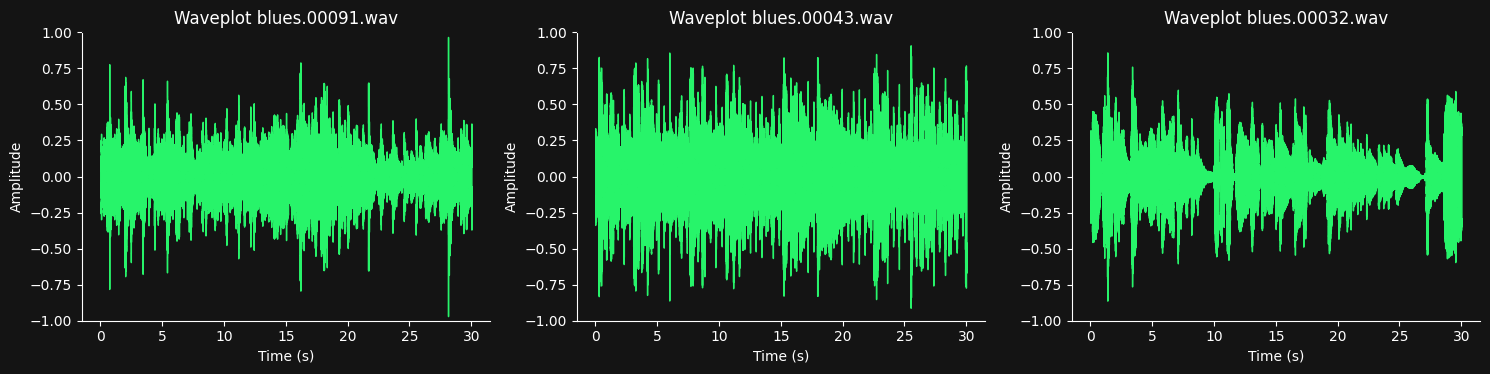

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/blues')

#### Classical

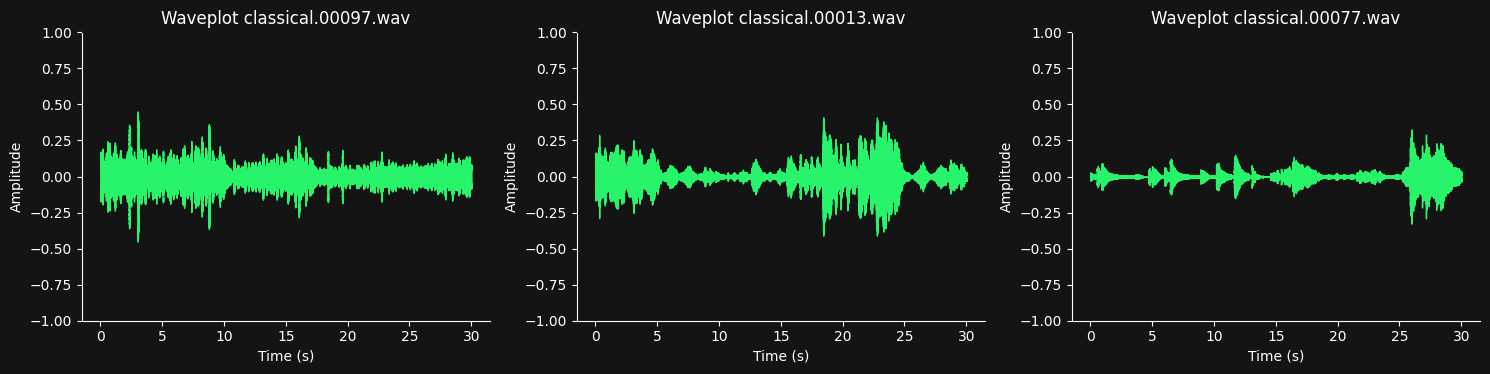

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/classical')

#### Country

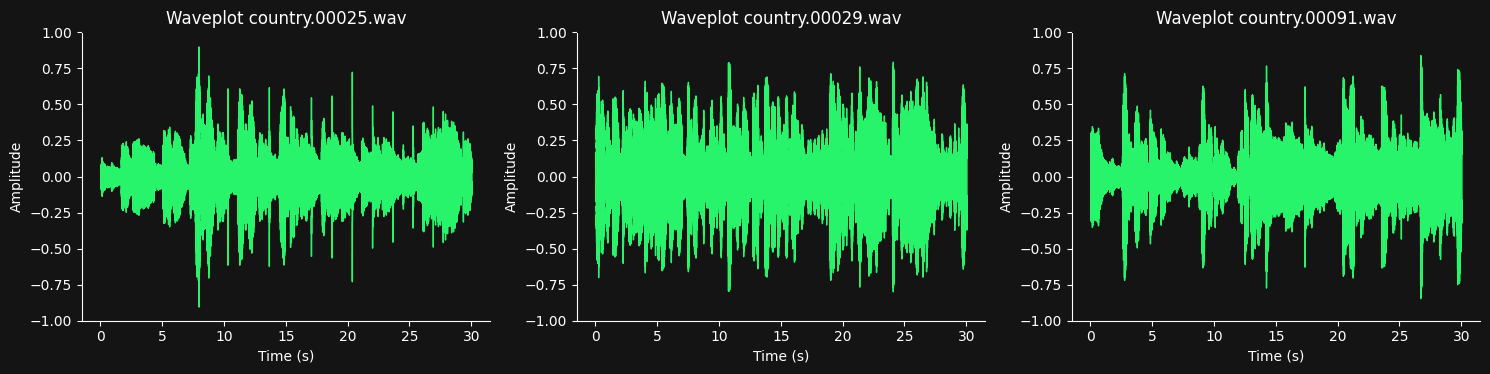

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/country')

#### Disco

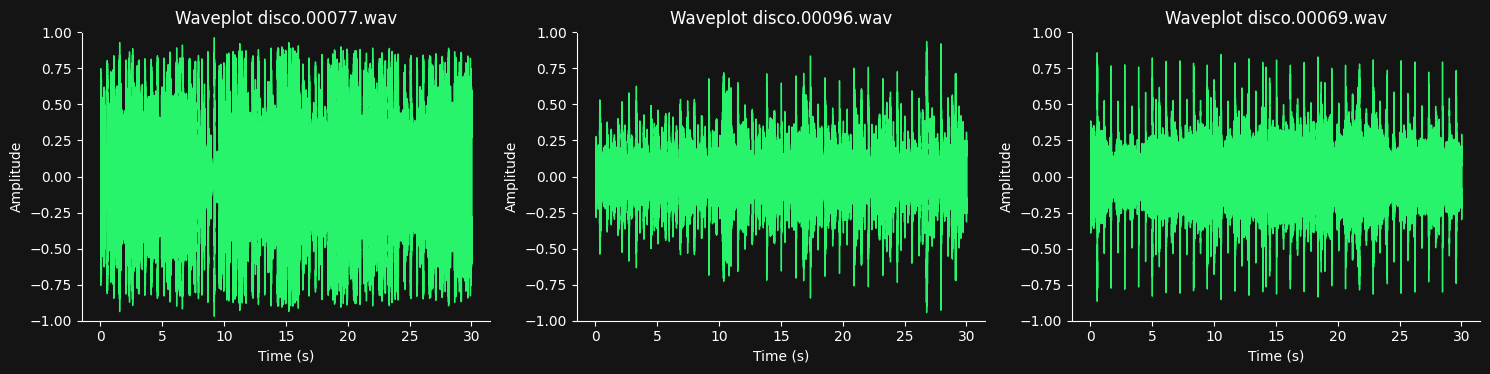

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/disco')

#### Hiphop

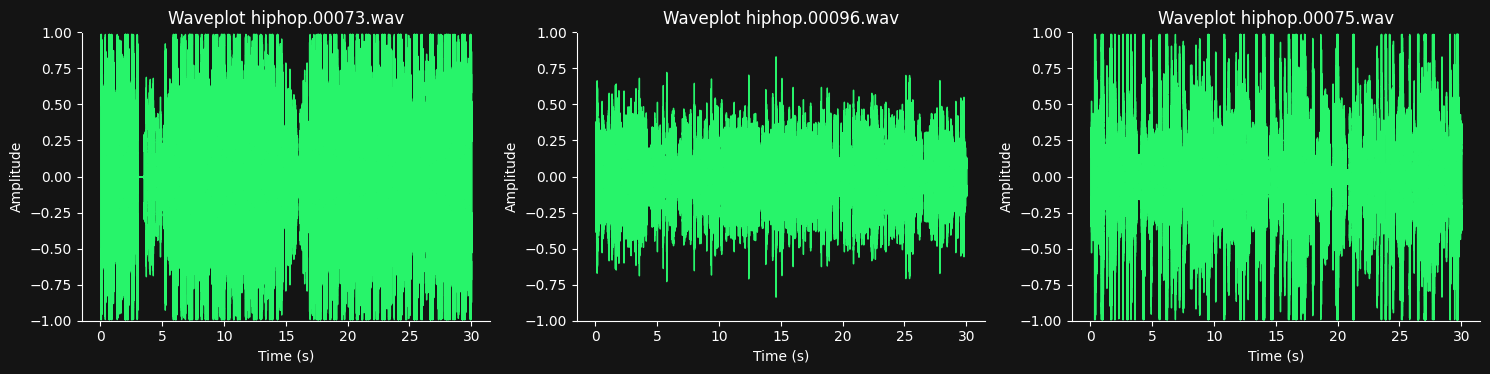

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/hiphop')

#### Jazz

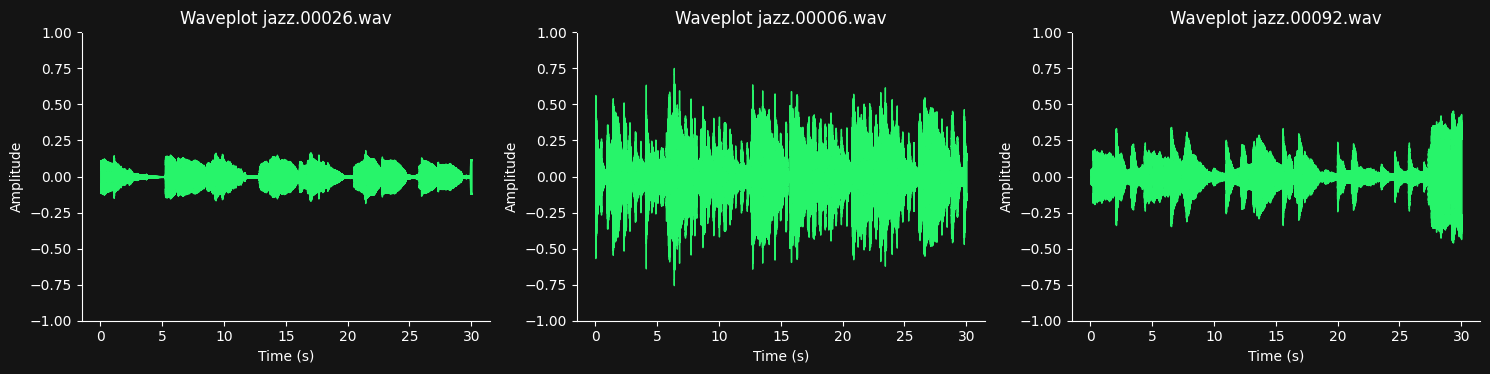

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/jazz')

#### Metal

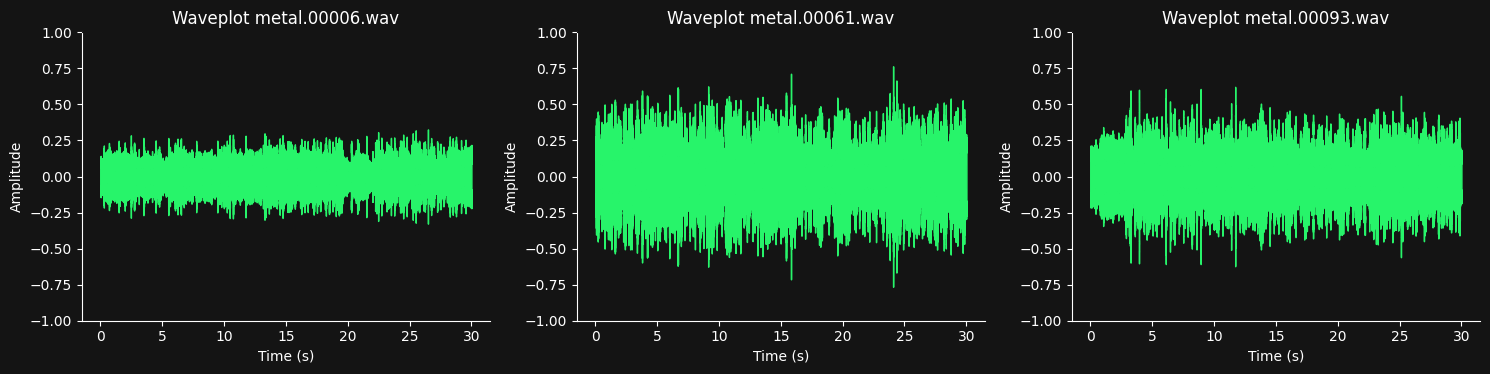

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/metal')

#### Pop

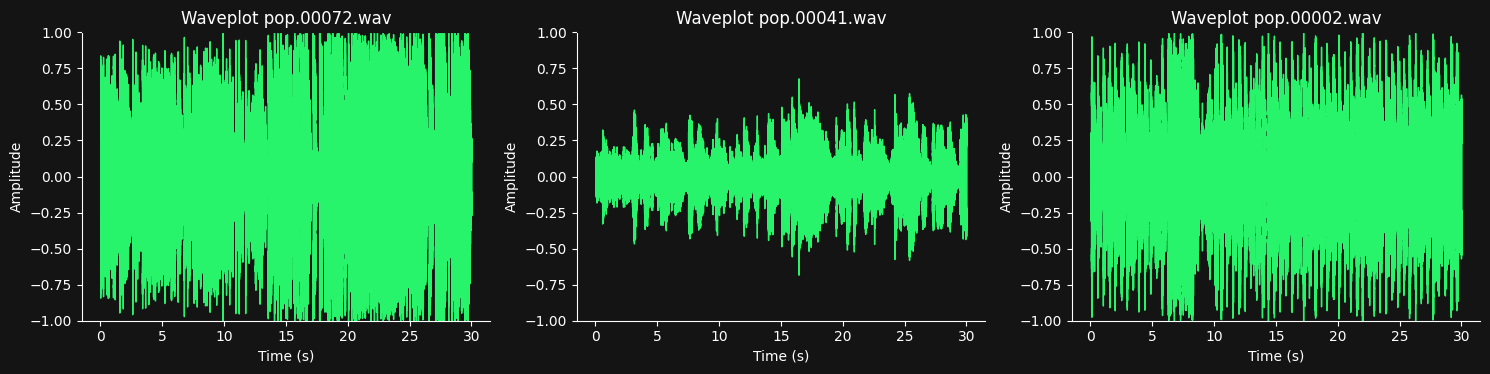

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/pop')

#### Reggae

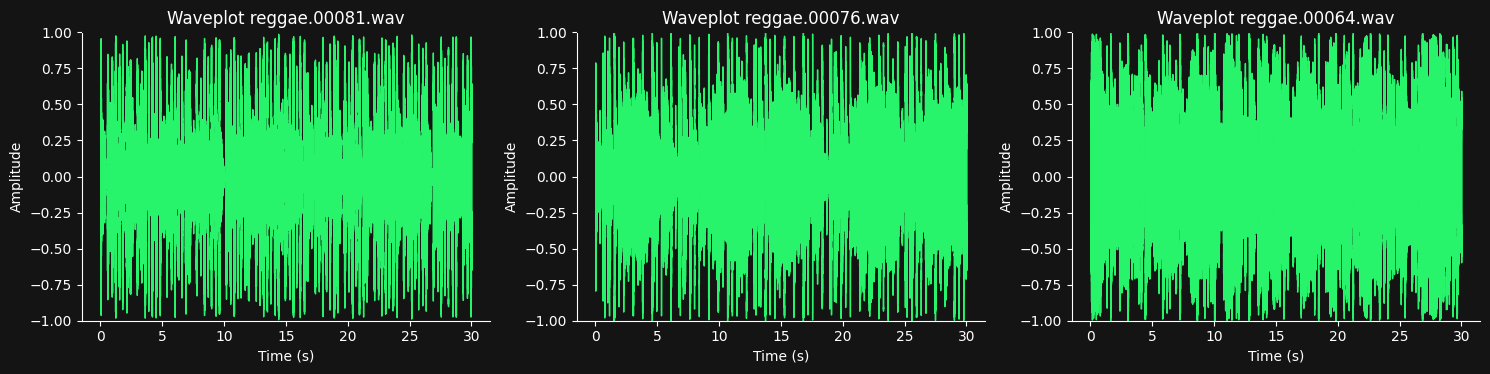

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/reggae')

#### Rock

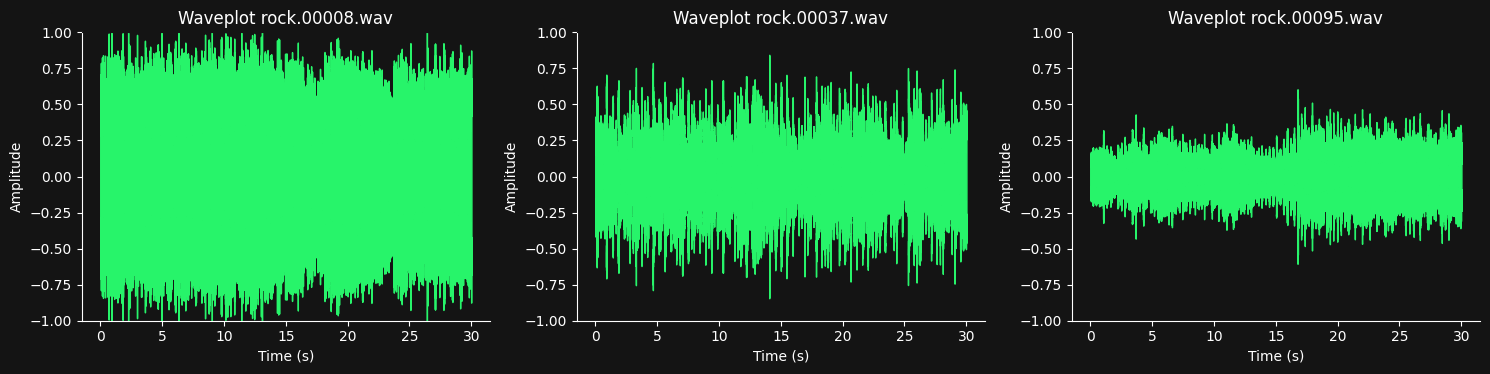

In [ ]:
# get the audio durations and output to a dataframe
get_waveplots('Data/genres_original/rock')

### Mel Frequency Cepstral Coefficients (MFCCs) Heatmaps <a class="anchor" id="5.2"></a>

In [ ]:
def plot_mfcc(base_path, num_to_plot=3, vmin=-300, vmax=100):

    # Define MFCC coefficient labels
    mfcc_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

    # iterate over all files in the directory
    for (dirpath, dirnames, filenames) in os.walk(base_path):

        # if dirpath == base_path:
              #   continue

        # collect all wav files
        wav_files = [f for f in filenames if f.endswith('.wav')]

        # calculate the number of rows and columns for subplots (want 3 columns)
        nrows = math.ceil(num_to_plot / 3)
        ncols = min(num_to_plot, 3)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
        fig.patch.set_facecolor('#141414')

        # ensure axes is always a 2D array
        axes = np.array(axes).reshape((nrows, ncols))

        # initialize i to -1 to handle cases where wav_files may be empty
        i = -1

        for i, f in enumerate(wav_files[:num_to_plot]):
            file_path = os.path.join(dirpath, f)

            try:
                # load the audio file with its original sampling rate
                y, sr = librosa.load(file_path, sr=None)
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

                # determine the position in the subplot grid
                row = i // ncols  # floor division
                col = i % ncols   # modulus

                # plot the waveplot on the corresponding subplot
                ax = axes[row, col]
                ax.set_title('MFCC ' + f,  color='white')
                img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax, vmin=vmin, vmax=vmax, cmap = 'viridis')
                ax.set_facecolor('#141414')
                ax.set_xlabel('Time (s)', color='white')
                ax.set_ylabel('MFCC Coefficients', color='white')
                ax.set_yticks(np.arange(0, 13))  # Set ticks for each coefficient
                ax.set_yticklabels(mfcc_labels)  # Set labels for each coefficient
                cbar = fig.colorbar(img, ax=ax)

                # Set colorbar text and tick colors
                cbar.ax.yaxis.set_tick_params(color='white')
                cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')
                cbar.outline.set_edgecolor('white')
                for label in cbar.ax.get_yticklabels():
                    label.set_color('white')


                # Set the axis color
                ax.spines['bottom'].set_color('white')
                ax.spines['top'].set_color('#141414')
                ax.spines['right'].set_color('#141414')
                ax.spines['left'].set_color('white')
                ax.tick_params(axis='x', colors='white')
                ax.tick_params(axis='y', colors='white')

            except Exception as e:
                print(f'Error loading {file_path}: {e}')

        # remove any empty subplots
        for j in range(i + 1, nrows * ncols):
          fig.delaxes(axes.flatten()[j])

        # adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

#### Blues

<ipython-input-178-9aba5c1c4952>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


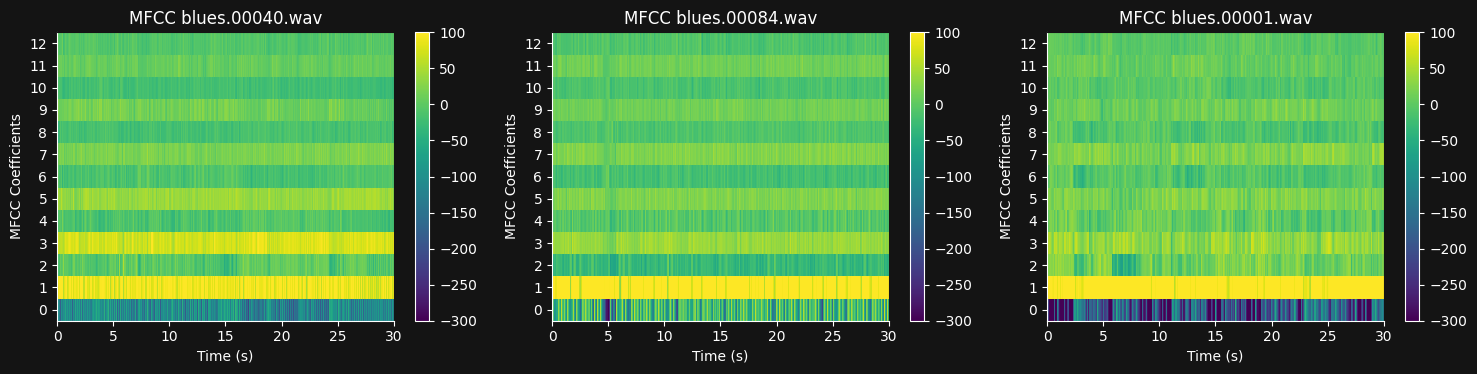

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/blues')

#### Classical

<ipython-input-178-9aba5c1c4952>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


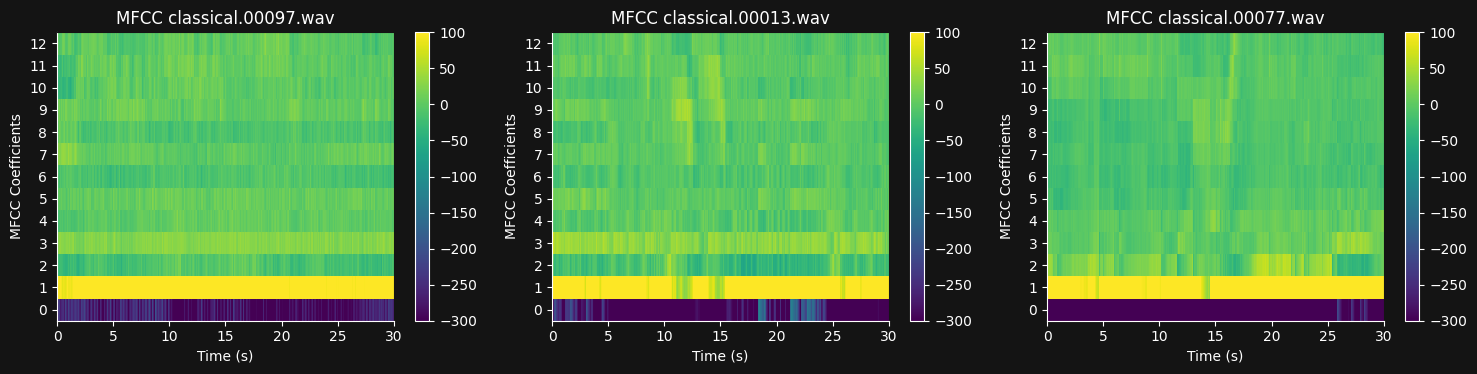

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/classical')

#### Country

<ipython-input-178-9aba5c1c4952>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


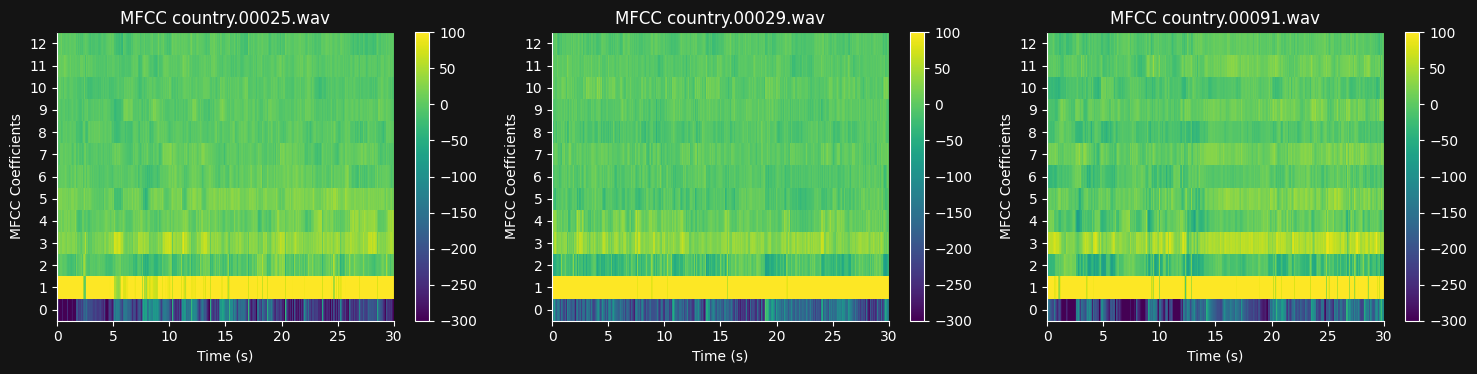

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/country')

#### Disco

<ipython-input-12-7eb4de3019fa>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


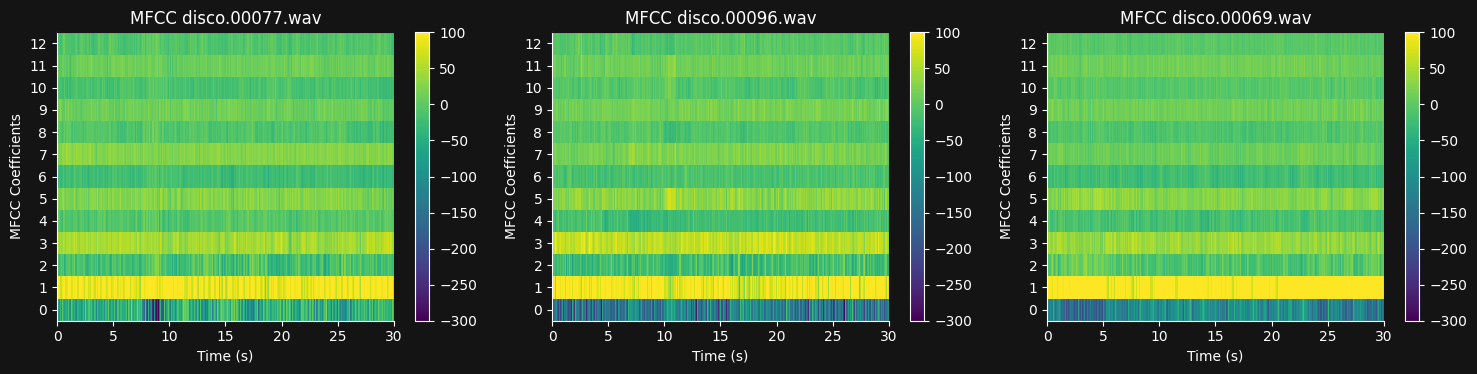

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/disco')

#### Hiphop

<ipython-input-178-9aba5c1c4952>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


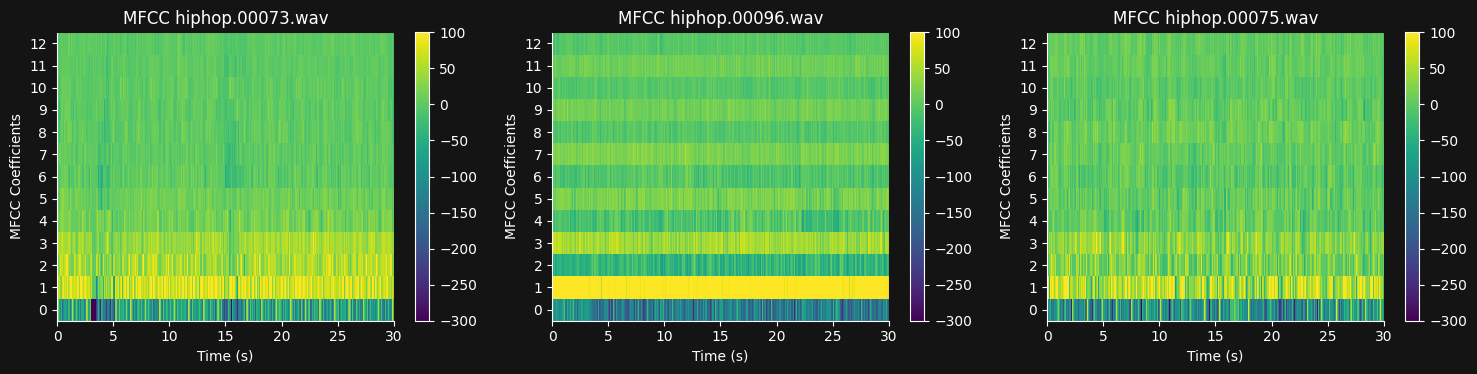

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/hiphop')

#### Jazz

<ipython-input-178-9aba5c1c4952>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


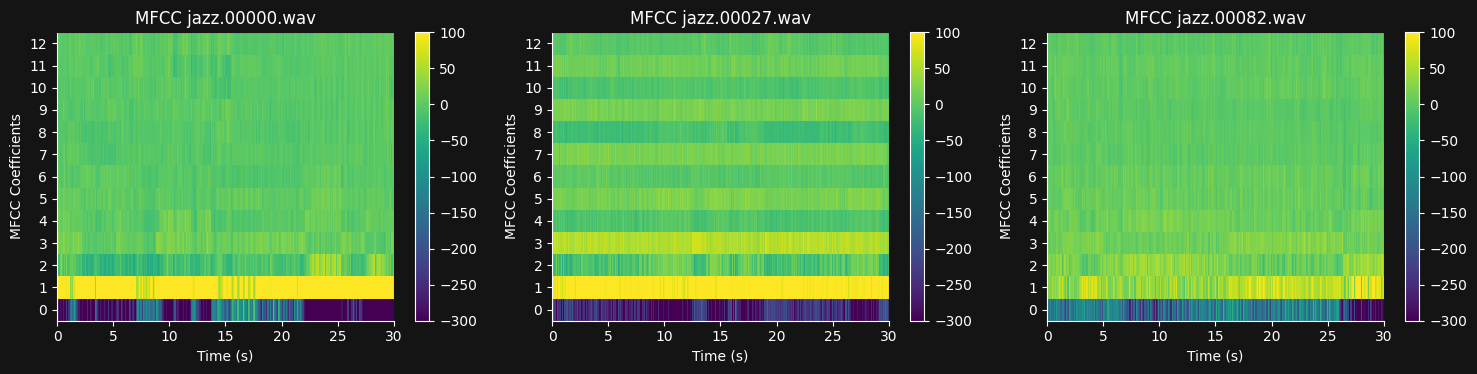

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/jazz')

#### Metal

<ipython-input-12-7eb4de3019fa>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


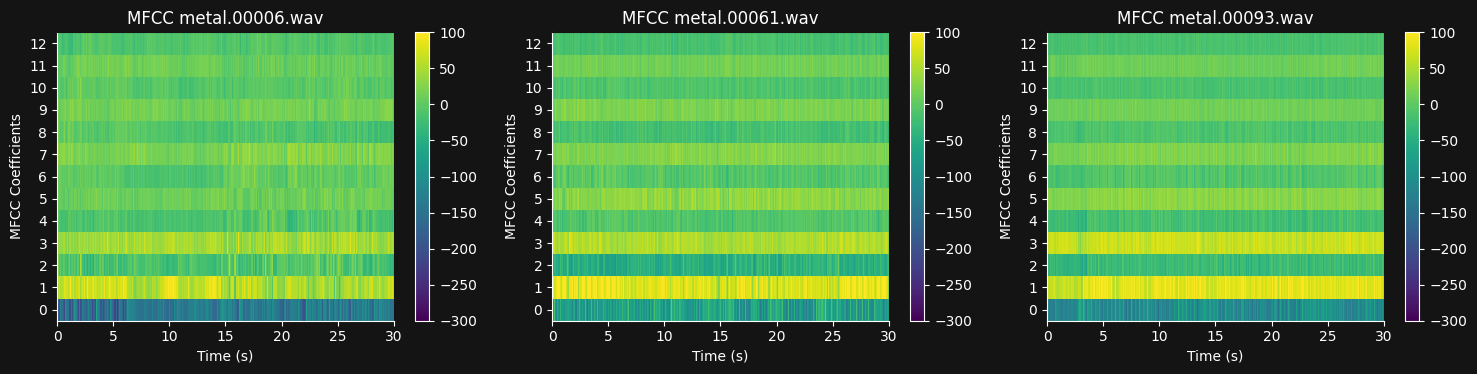

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/metal')

#### Pop

<ipython-input-12-7eb4de3019fa>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


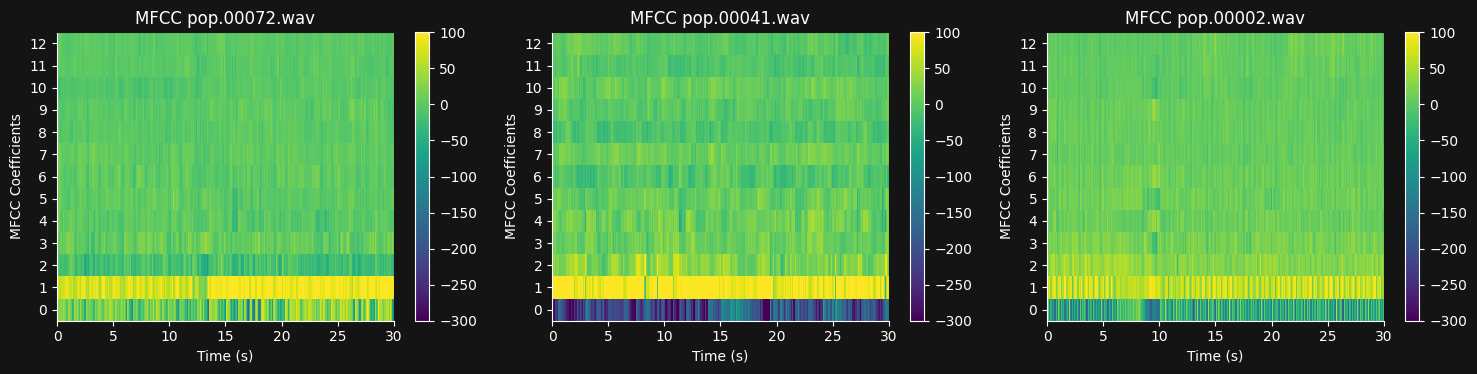

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/pop')

#### Reggae

<ipython-input-12-7eb4de3019fa>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


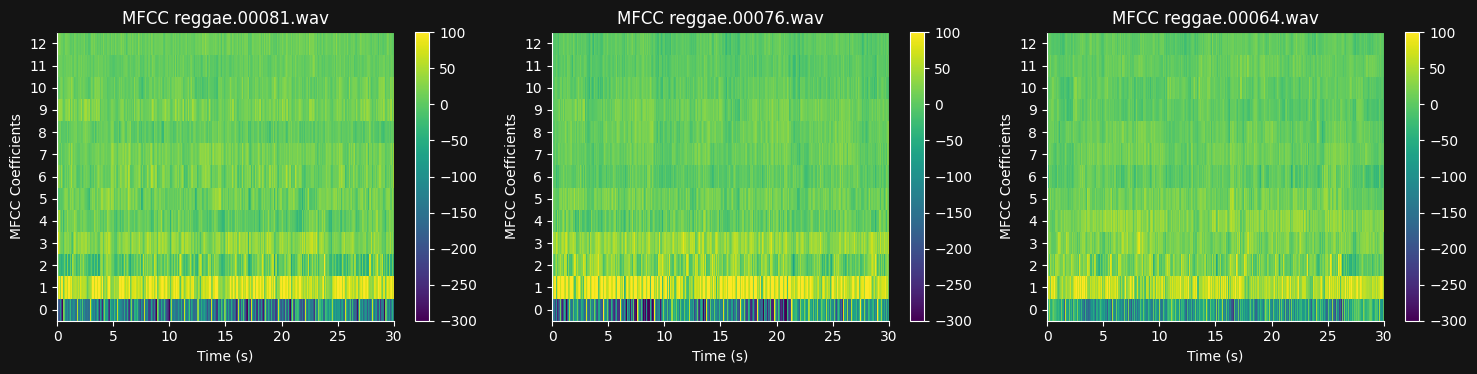

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/reggae')

#### Rock

<ipython-input-12-7eb4de3019fa>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


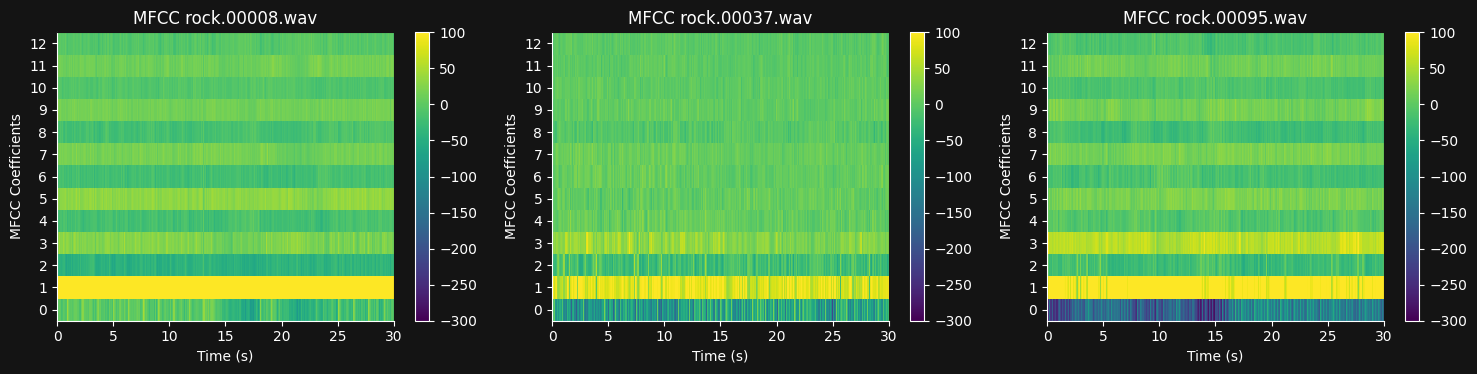

In [ ]:
# get the audio durations and output to a dataframe
plot_mfcc('Data/genres_original/rock')

### Mel Spectograms <a class="anchor" id="5.3"></a>

In [ ]:
def plot_melspec(base_path, num_to_plot=3):

    # iterate over all files in the directory
    for (dirpath, dirnames, filenames) in os.walk(base_path):

        # if dirpath == base_path:
              #   continue

        # collect all wav files
        wav_files = [f for f in filenames if f.endswith('.wav')]

        # calculate the number of rows and columns for subplots (want 3 columns)
        nrows = math.ceil(num_to_plot / 3)
        ncols = min(num_to_plot, 3)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
        fig.patch.set_facecolor('#141414')

        # ensure axes is always a 2D array
        axes = np.array(axes).reshape((nrows, ncols))

        # initialize i to -1 to handle cases where wav_files may be empty
        i = -1

        for i, f in enumerate(wav_files[:num_to_plot]):
            file_path = os.path.join(dirpath, f)

            try:
                # load the audio file with its original sampling rate
                y, sr = librosa.load(file_path, sr=None)
                melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)

                # determine the position in the subplot grid
                row = i // ncols  # floor division
                col = i % ncols   # modulus

                # plot the waveplot on the corresponding subplot
                ax = axes[row, col]
                ax.set_title('Mel Spectogram ' + f,  color='white')
                ax.set_facecolor('#141414')
                img = librosa.display.specshow(melspectrogram_db, sr=sr, x_axis='time', y_axis='mel', ax=ax, cmap ='viridis')
                ax.set_xlabel('Time (s)', color='white')
                ax.set_ylabel('Frequency (Hz)', color='white')
                ax.tick_params(axis='x', colors='white')  # Set color for x-axis ticks
                ax.tick_params(axis='y', colors='white')  # Set color for y-axis ticks

                cbar = fig.colorbar(img, ax=ax)

                # Set colorbar text and tick colors
                cbar.ax.yaxis.set_tick_params(color='white')
                cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')
                cbar.outline.set_edgecolor('white')
                for label in cbar.ax.get_yticklabels():
                    label.set_color('white')

            except Exception as e:
                print(f'Error loading {file_path}: {e}')

        # remove any empty subplots
        for j in range(i + 1, nrows * ncols):
          fig.delaxes(axes.flatten()[j])

        # adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

#### Blues

<ipython-input-18-a041e85d5e12>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


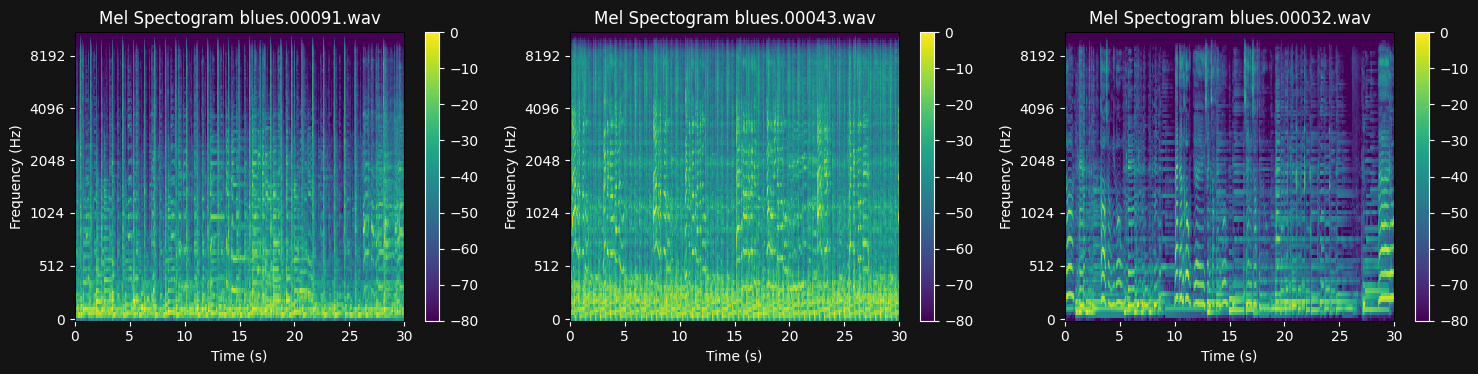

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/blues')

#### Classical

<ipython-input-187-6e83b0d63e3a>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


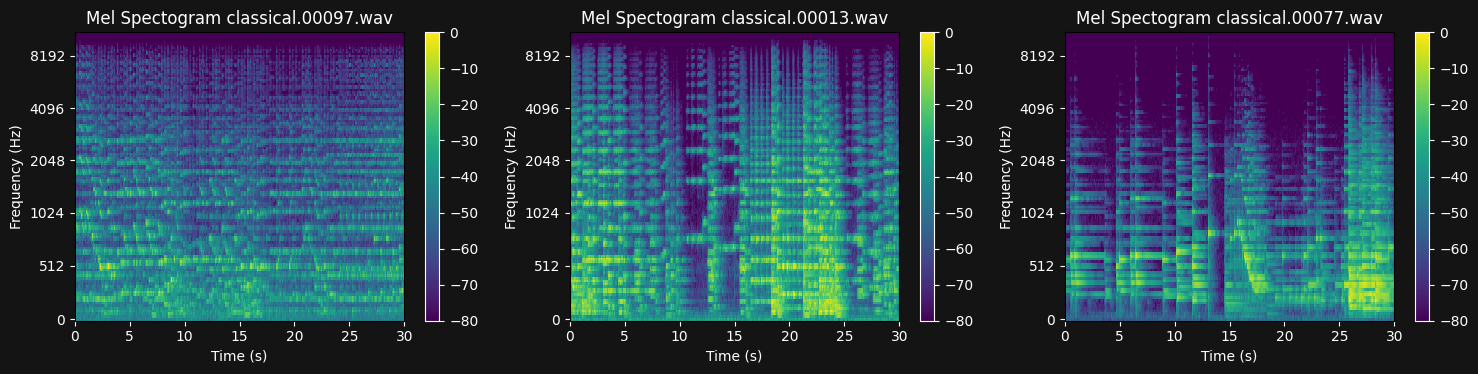

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/classical')

#### Country

<ipython-input-187-6e83b0d63e3a>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


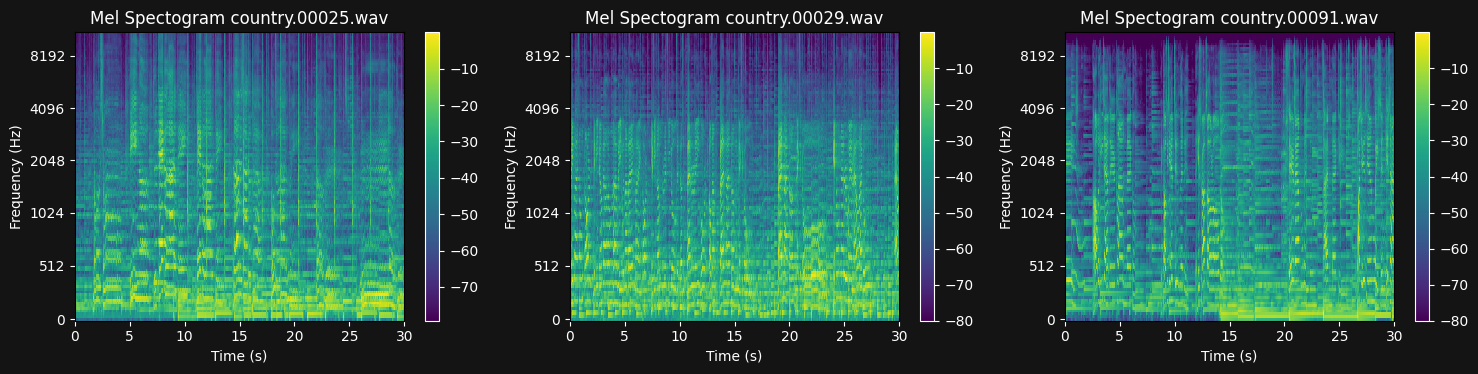

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/country')

#### Disco

<ipython-input-18-a041e85d5e12>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


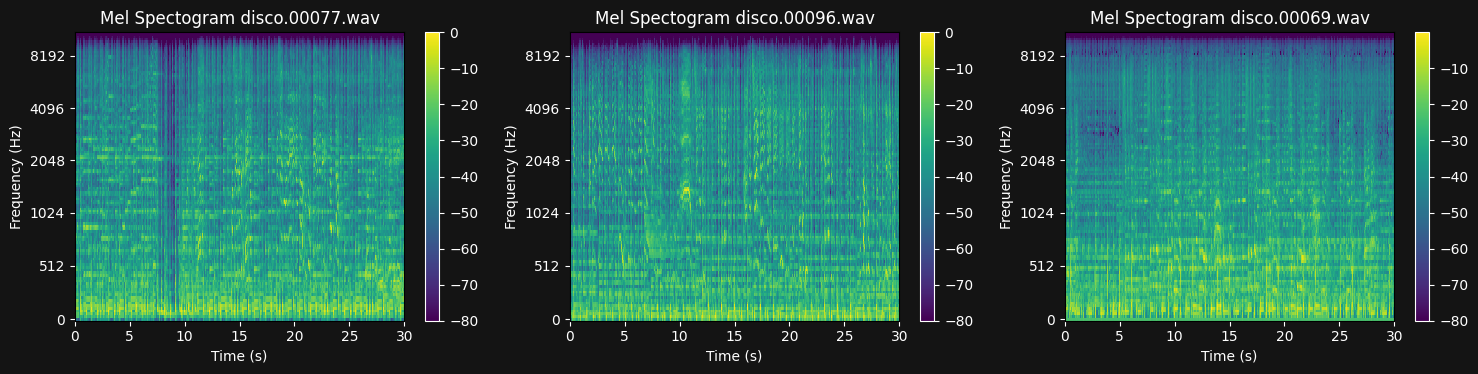

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/disco')

#### Hiphop

<ipython-input-187-6e83b0d63e3a>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


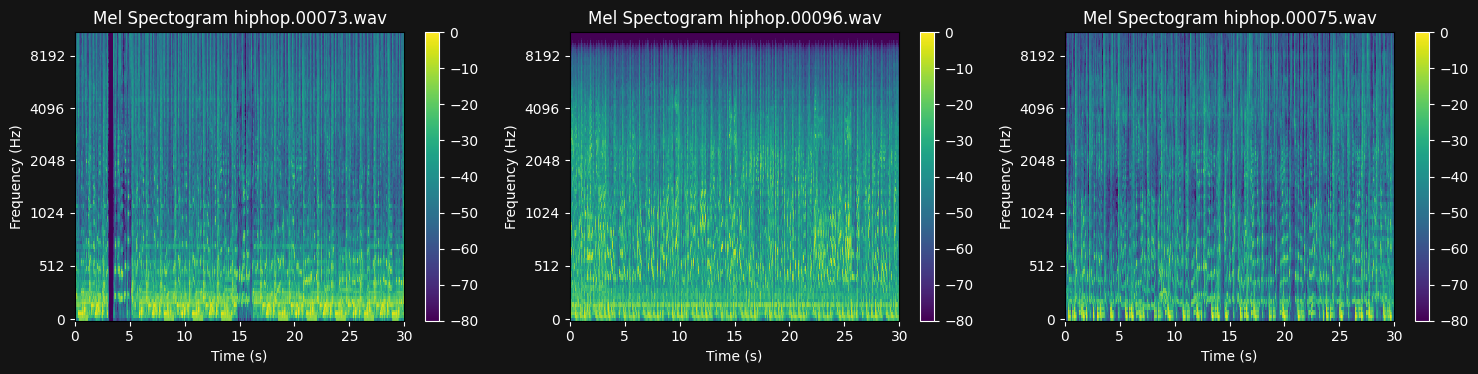

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/hiphop')

#### Jazz

<ipython-input-187-6e83b0d63e3a>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


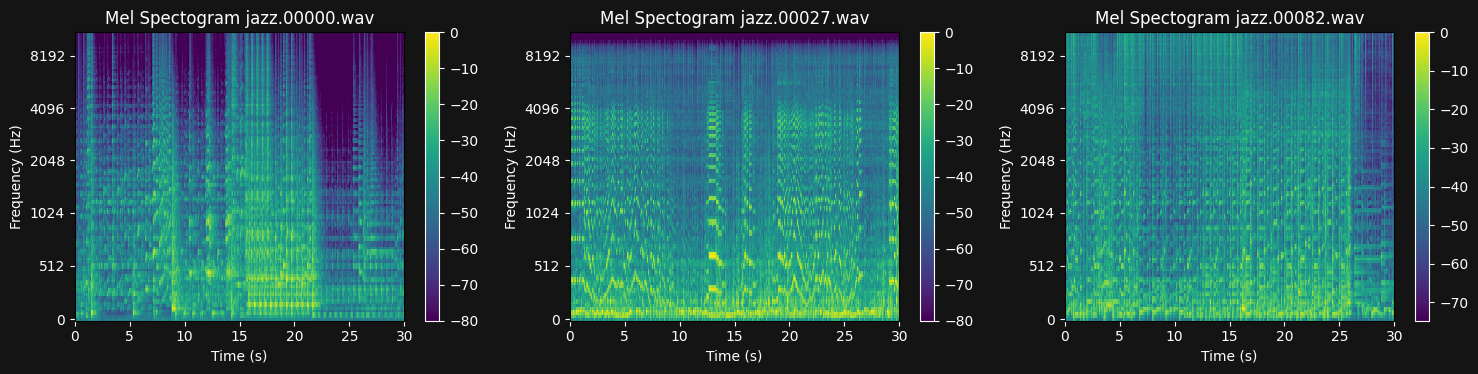

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/jazz')

#### Metal

<ipython-input-187-6e83b0d63e3a>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


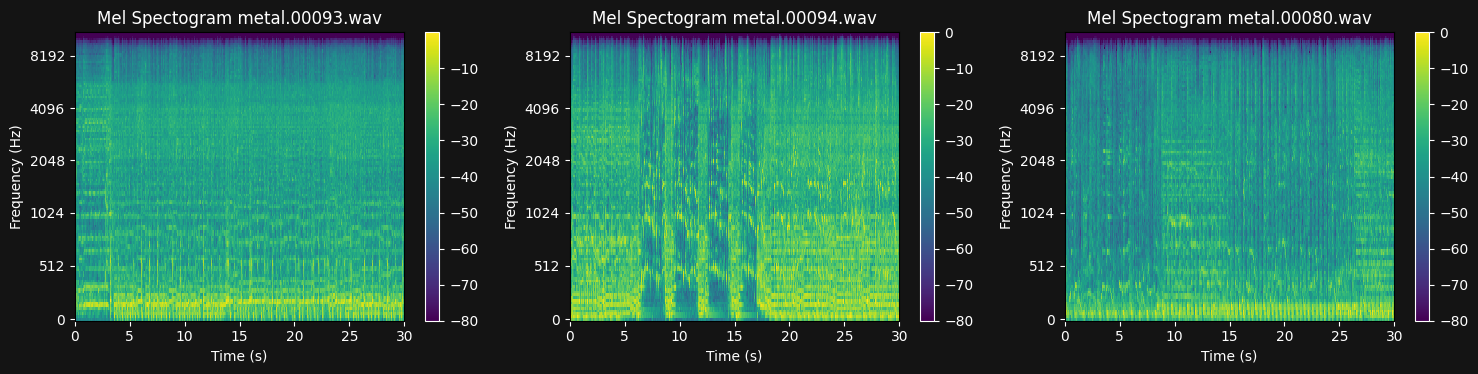

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/metal')

#### Pop

<ipython-input-18-a041e85d5e12>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


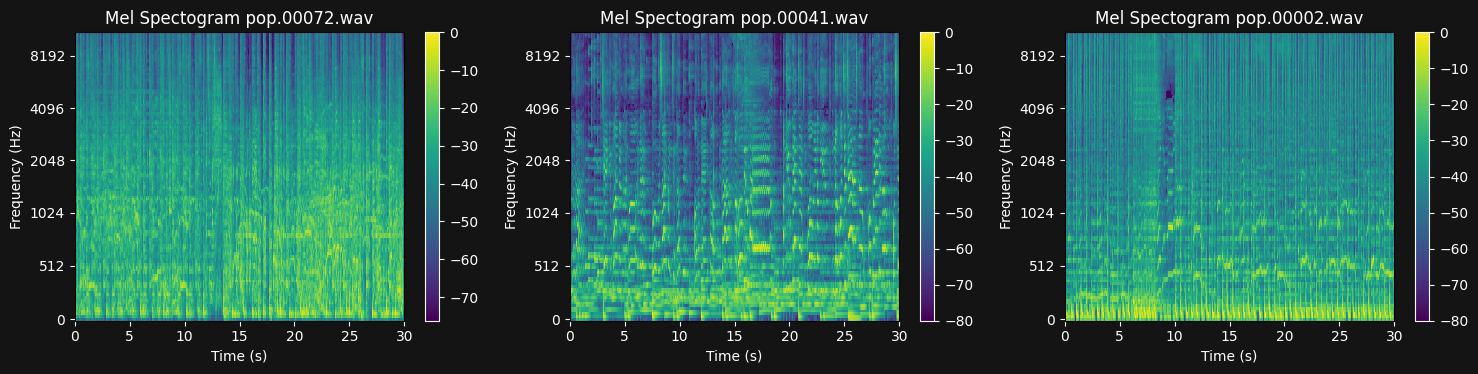

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/pop')

#### Reggae

<ipython-input-18-a041e85d5e12>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


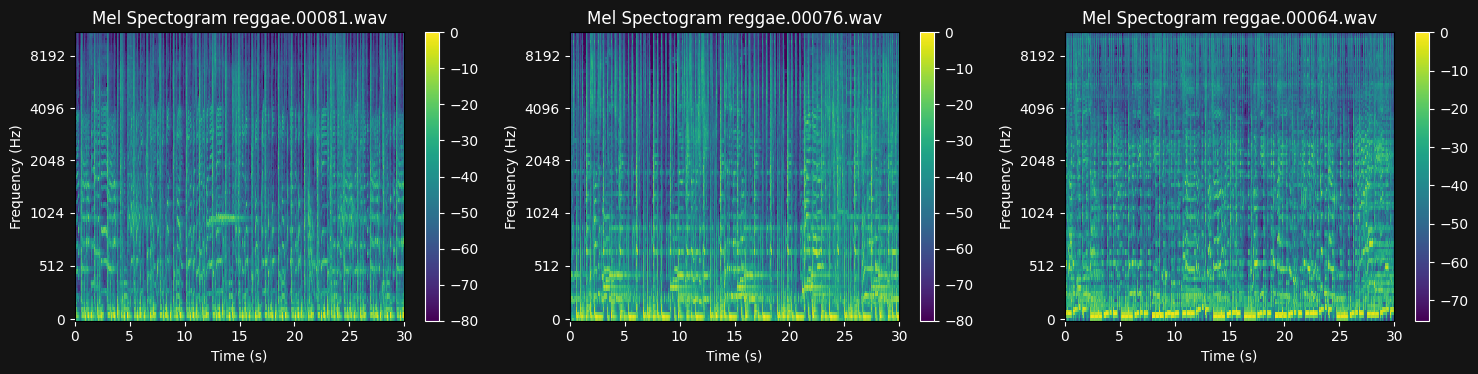

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/reggae')

#### Rock

<ipython-input-187-6e83b0d63e3a>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


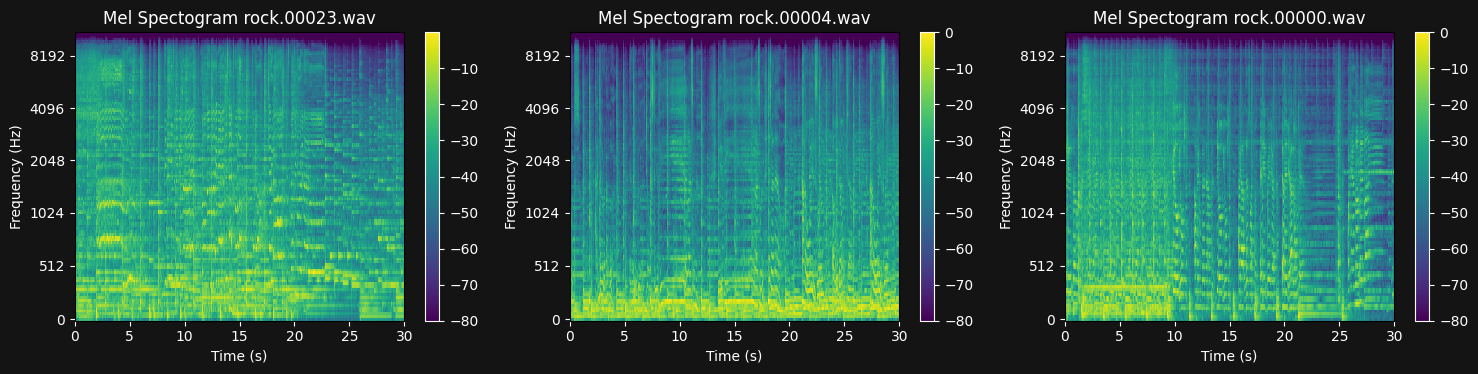

In [ ]:
# get the audio durations and output to a dataframe
plot_melspec('Data/genres_original/rock')

### Chroma Vectors <a class="anchor" id="5.4"></a>

In [ ]:
def plot_chroma(base_path, num_to_plot=3):

    # define pitch classes (chroma)
    pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # iterate over all files in the directory
    for (dirpath, dirnames, filenames) in os.walk(base_path):

        # if dirpath == base_path:
              #   continue

        # collect all wav files
        wav_files = [f for f in filenames if f.endswith('.wav')]

        # calculate the number of rows and columns for subplots (want 3 columns)
        nrows = math.ceil(num_to_plot / 3)
        ncols = min(num_to_plot, 3)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
        fig.patch.set_facecolor('#141414')

        # ensure axes is always a 2D array
        axes = np.array(axes).reshape((nrows, ncols))

        # initialize i to -1 to handle cases where wav_files may be empty
        i = -1

        for i, f in enumerate(wav_files[:num_to_plot]):
            file_path = os.path.join(dirpath, f)

            try:
                # load the audio file with its original sampling rate
                y, sr = librosa.load(file_path, sr=None)
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)

                # determine the position in the subplot grid
                row = i // ncols  # floor division
                col = i % ncols   # modulus

                # plot the waveplot on the corresponding subplot
                ax = axes[row, col]
                ax.set_title('Chroma Vector ' + f,  color='white')
                img = librosa.display.specshow(chroma, sr=sr, x_axis='time', ax=ax, cmap = 'viridis')
                ax.set_facecolor('#141414')
                ax.set_xlabel('Time (s)', color='white')
                ax.set_ylabel('Pitch Class', color='white')
                ax.set_yticks(np.arange(0,12))  # 12 pitch classes
                ax.set_yticklabels(pitch_classes)
                ax.tick_params(axis='x', colors='white')  # Set color for x-axis ticks
                ax.tick_params(axis='y', colors='white')  # Set color for y-axis ticks

                cbar = fig.colorbar(img, ax=ax)
                # Set colorbar text and tick colors
                cbar.ax.yaxis.set_tick_params(color='white')
                cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')
                cbar.outline.set_edgecolor('white')
                for label in cbar.ax.get_yticklabels():
                    label.set_color('white')

            except Exception as e:
                print(f'Error loading {file_path}: {e}')

        # remove any empty subplots
        for j in range(i + 1, nrows * ncols):
          fig.delaxes(axes.flatten()[j])

        # adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

#### Blues

<ipython-input-195-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


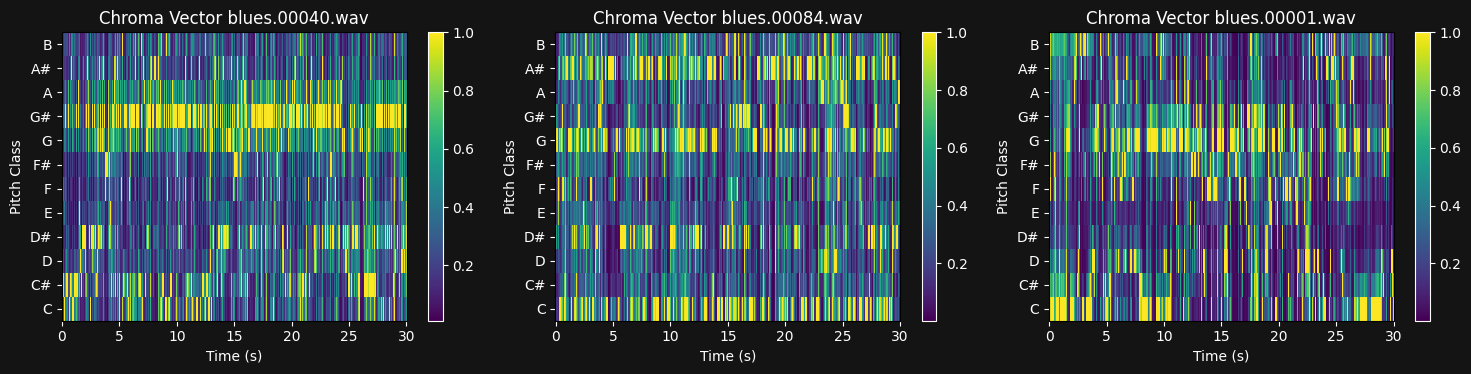

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/blues')

#### Classical

<ipython-input-195-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


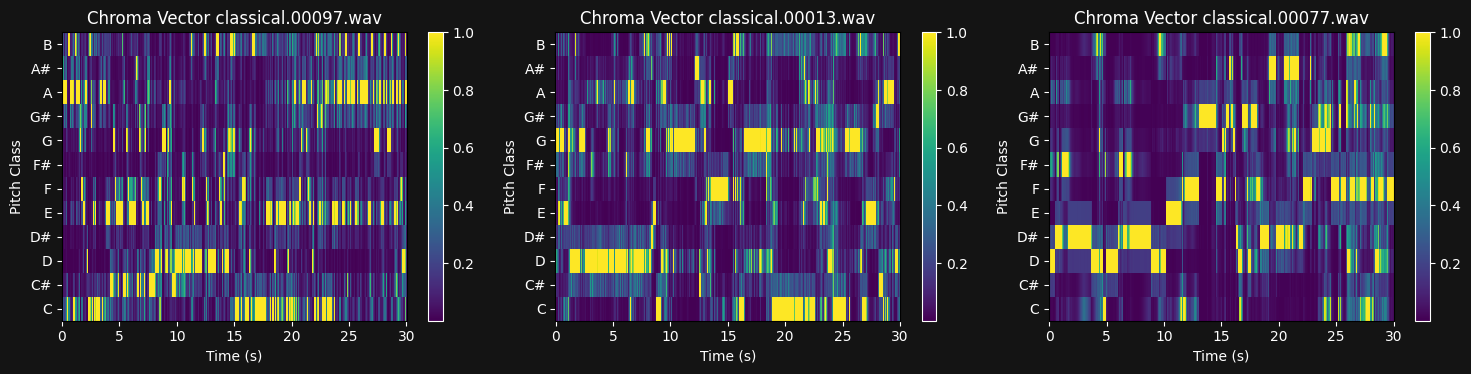

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/classical')

#### Country

<ipython-input-195-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


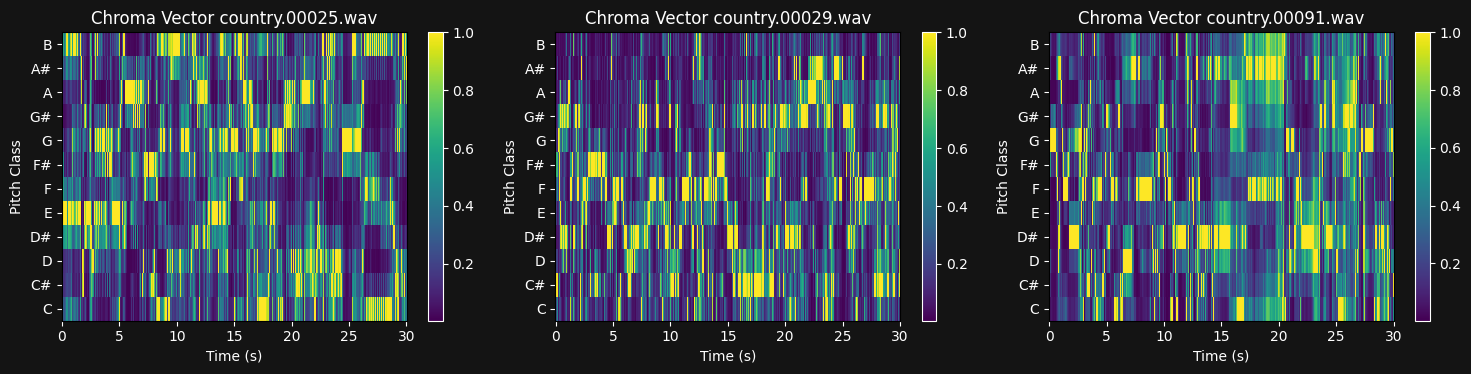

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/country')

#### Disco

<ipython-input-195-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


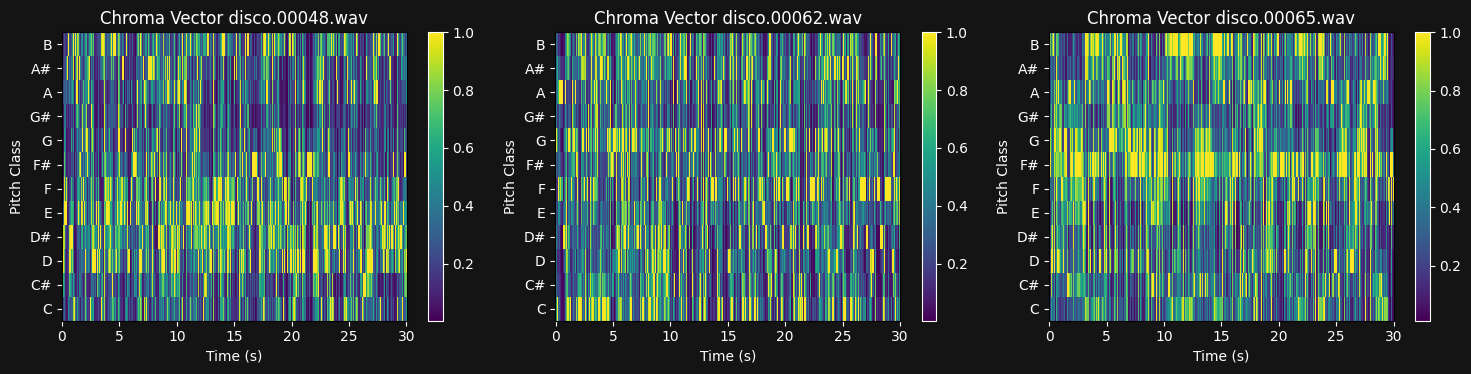

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/disco')

#### Hiphop

<ipython-input-195-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


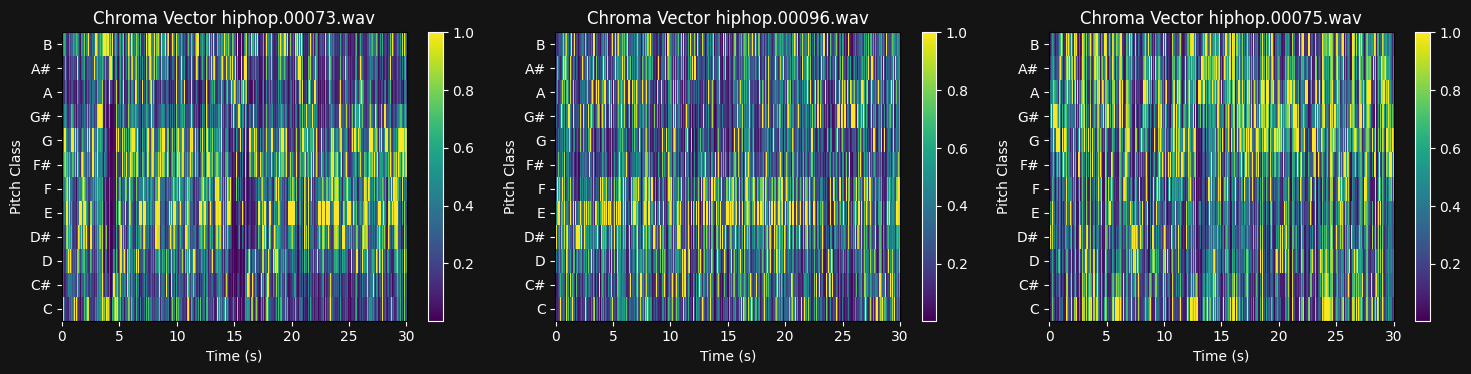

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/hiphop')

#### Jazz

<ipython-input-195-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


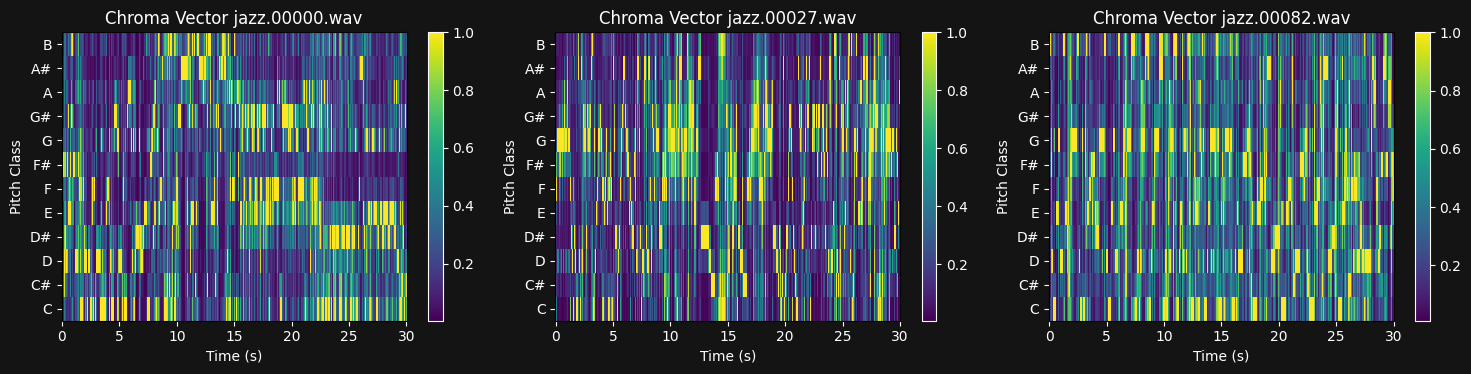

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/jazz')

#### Metal

<ipython-input-195-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


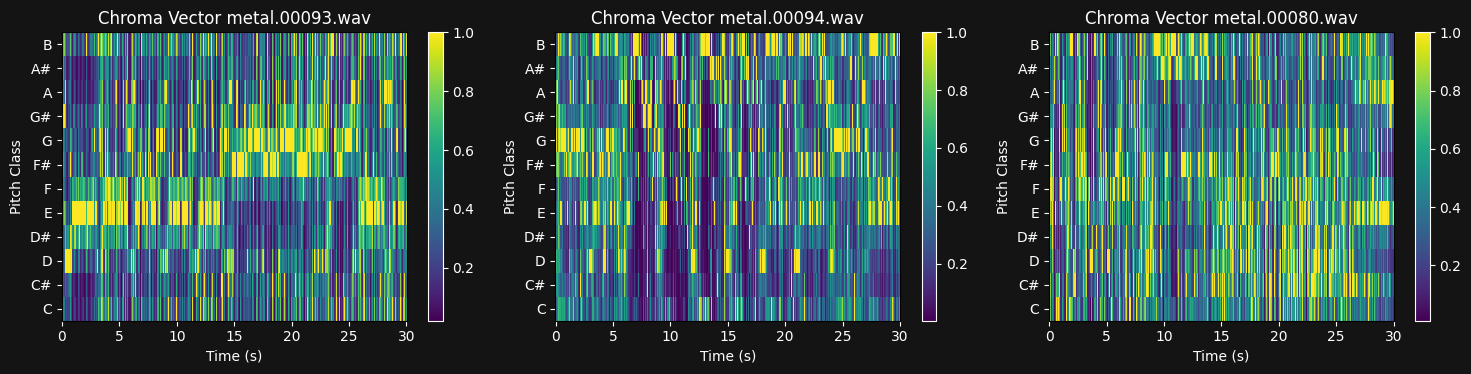

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/metal')

#### Pop

<ipython-input-195-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


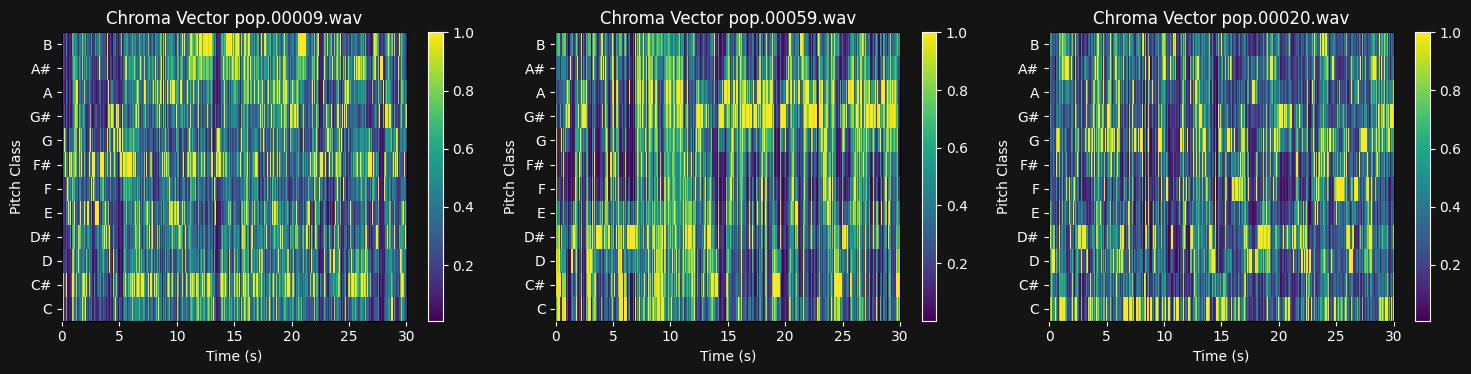

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/pop')

#### Reggae

<ipython-input-23-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


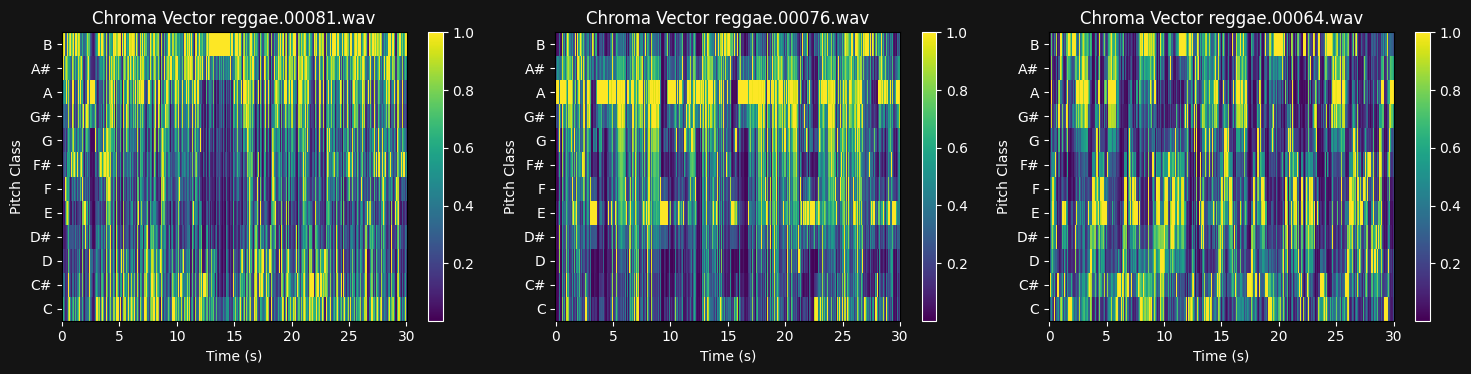

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/reggae')

#### Rock

<ipython-input-23-0cc9c85381b8>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


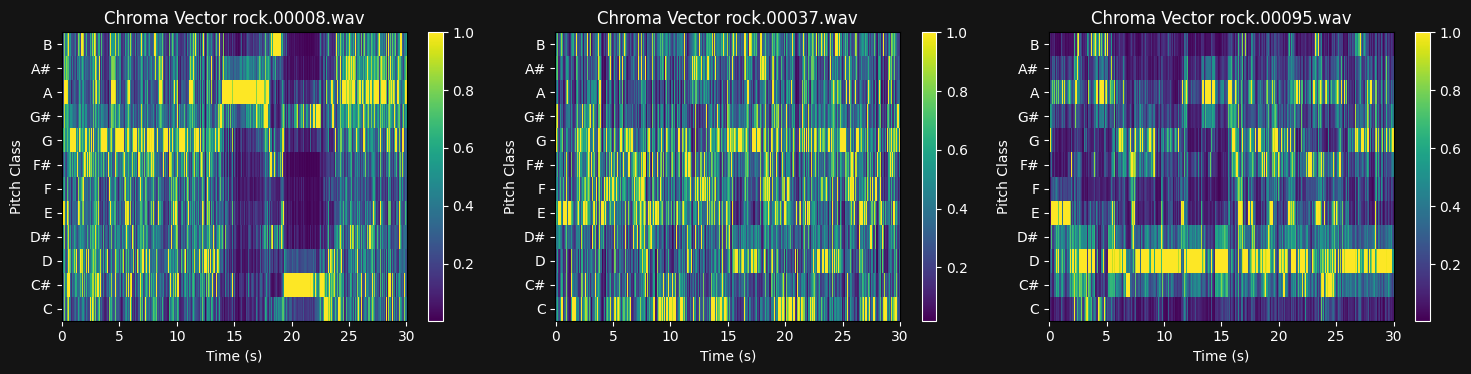

In [ ]:
# get the audio durations and output to a dataframe
plot_chroma('Data/genres_original/rock')

### Tonal Centroids <a class="anchor" id="5.5"></a>

In [ ]:
def plot_tonnetz(base_path, num_to_plot=3):

    # labels for tonnetz dimensions
    tonnetz_labels = ['5x', '5y', 'm3x', 'm3y', 'M3x', 'M3y']

    # iterate over all files in the directory
    for (dirpath, dirnames, filenames) in os.walk(base_path):

        # if dirpath == base_path:
              #   continue

        # collect all wav files
        wav_files = [f for f in filenames if f.endswith('.wav')]

        # calculate the number of rows and columns for subplots (want 3 columns)
        nrows = math.ceil(num_to_plot / 3)
        ncols = min(num_to_plot, 3)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
        fig.patch.set_facecolor('#141414')

        # ensure axes is always a 2D array
        axes = np.array(axes).reshape((nrows, ncols))

        # initialize i to -1 to handle cases where wav_files may be empty
        i = -1

        for i, f in enumerate(wav_files[:num_to_plot]):
            file_path = os.path.join(dirpath, f)

            try:
                # load the audio file with its original sampling rate
                y, sr = librosa.load(file_path, sr=None)
                tntz = librosa.feature.tonnetz(y=y, sr=sr)

                # determine the position in the subplot grid
                row = i // ncols  # floor division
                col = i % ncols   # modulus

                # plot the waveplot on the corresponding subplot
                ax = axes[row, col]
                ax.set_title('Tonnetz ' + f, color='white')
                ax.set_facecolor('#141414')
                img = librosa.display.specshow(tntz, sr=sr, x_axis='time', ax=ax, cmap='viridis')
                ax.set_xlabel('Time (s)', color='white')
                ax.set_ylabel('Tonnetz', color='white')
                ax.set_yticks(np.arange(0,6))  # 12 pitch classes
                ax.set_yticklabels(tonnetz_labels)  # Set custom y-axis labels
                cbar = fig.colorbar(img, ax=ax)

                # Set colorbar text and tick colors
                cbar.ax.yaxis.set_tick_params(color='white')
                cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')
                cbar.outline.set_edgecolor('white')
                for label in cbar.ax.get_yticklabels():
                    label.set_color('white')


                # Set the axis color
                ax.spines['bottom'].set_color('white')
                ax.spines['top'].set_color('#141414')
                ax.spines['right'].set_color('#141414')
                ax.spines['left'].set_color('white')
                ax.tick_params(axis='x', colors='white')
                ax.tick_params(axis='y', colors='white')

            except Exception as e:
                print(f'Error loading {file_path}: {e}')

        # remove any empty subplots
        for j in range(i + 1, nrows * ncols):
          fig.delaxes(axes.flatten()[j])

        # adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

#### Blues

<ipython-input-211-501d299319de>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


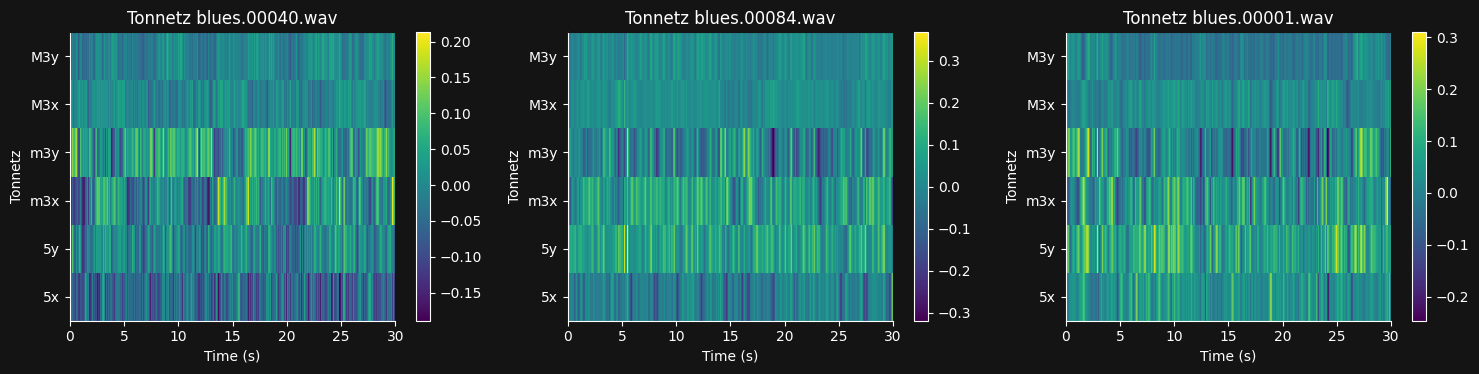

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/blues')

#### Classical

<ipython-input-26-7de228fa64a6>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


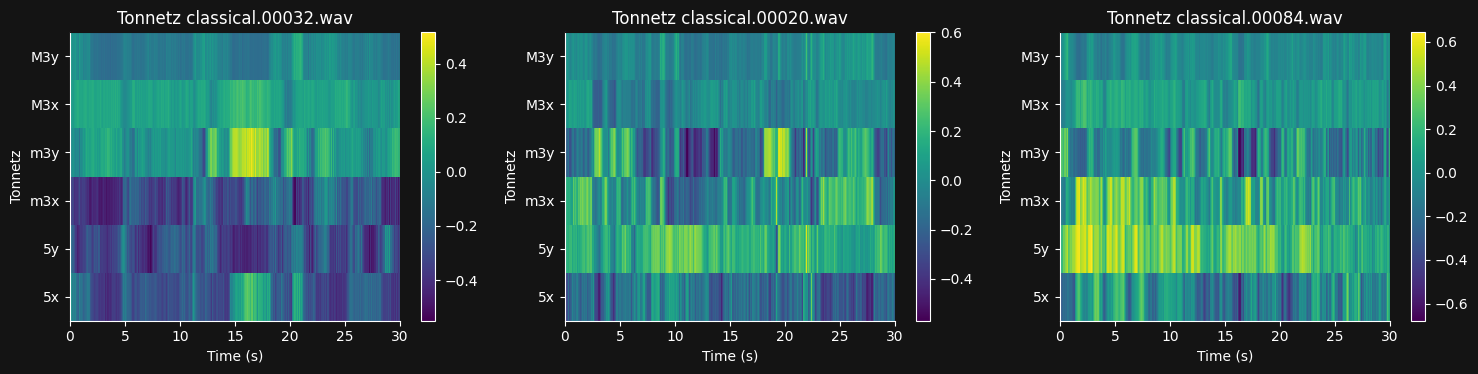

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/classical')

#### Country

<ipython-input-26-7de228fa64a6>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


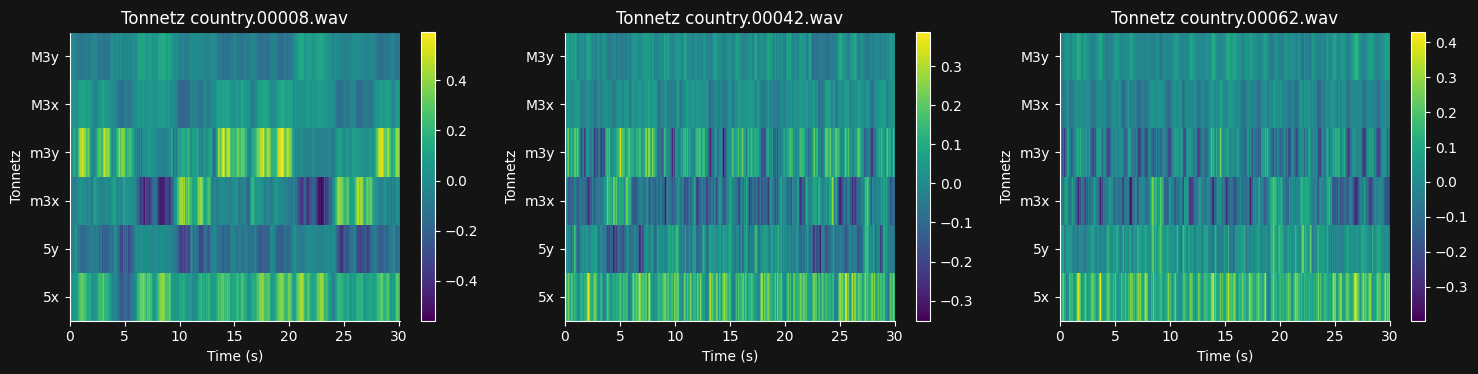

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/country')

#### Disco

<ipython-input-26-7de228fa64a6>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


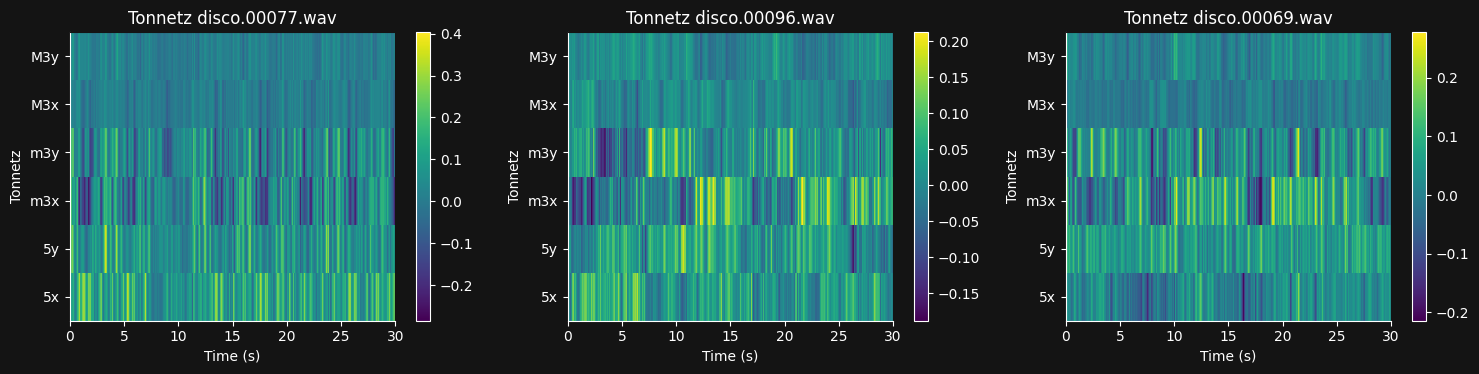

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/disco')

#### Hiphop

<ipython-input-26-7de228fa64a6>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


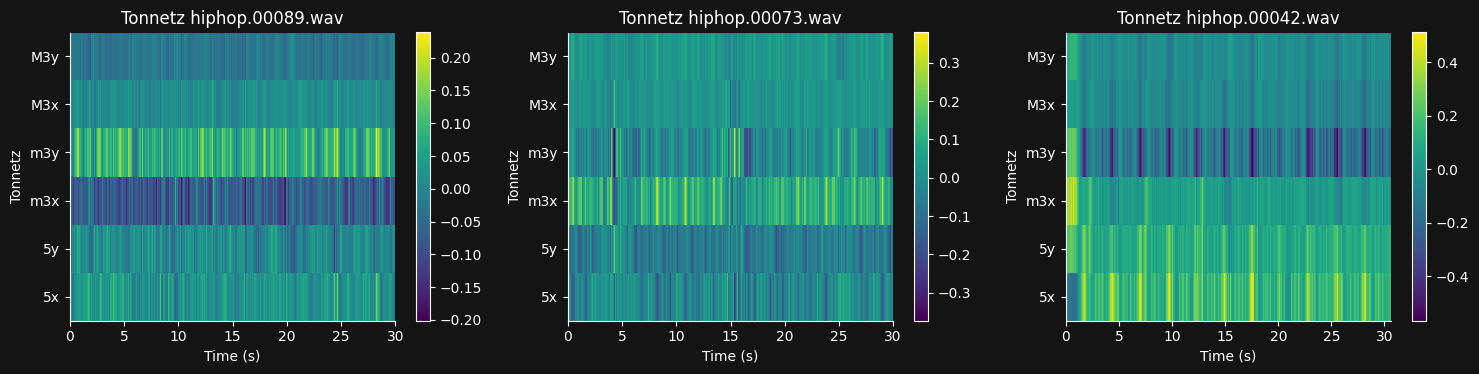

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/hiphop')

#### Jazz

<ipython-input-26-7de228fa64a6>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


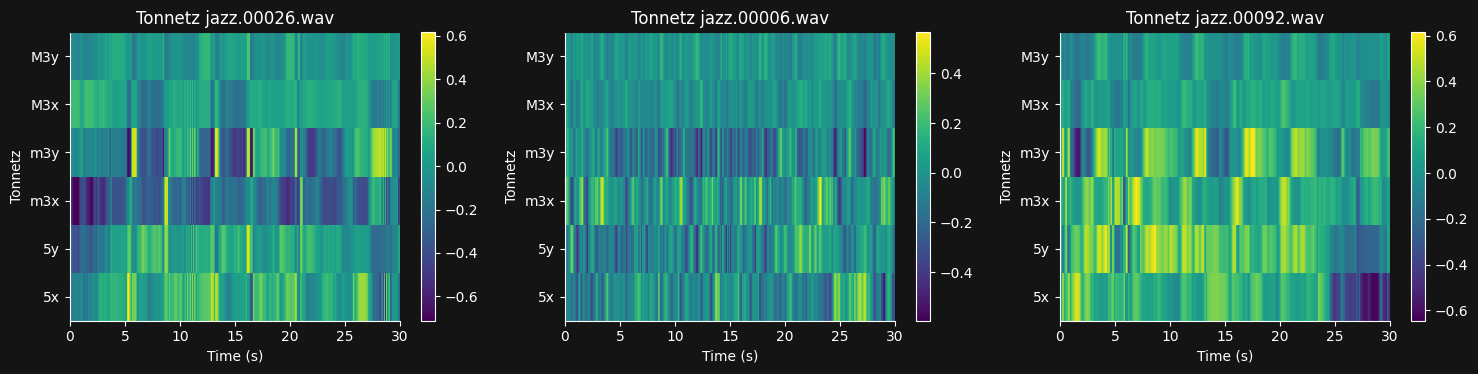

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/jazz')

#### Metal

<ipython-input-26-7de228fa64a6>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


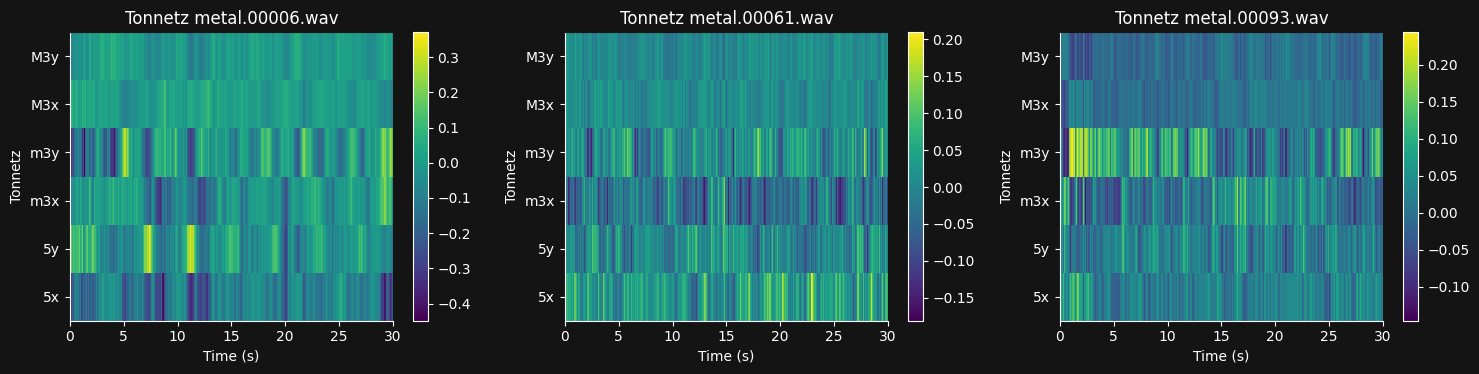

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/metal')

#### Pop

<ipython-input-211-501d299319de>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


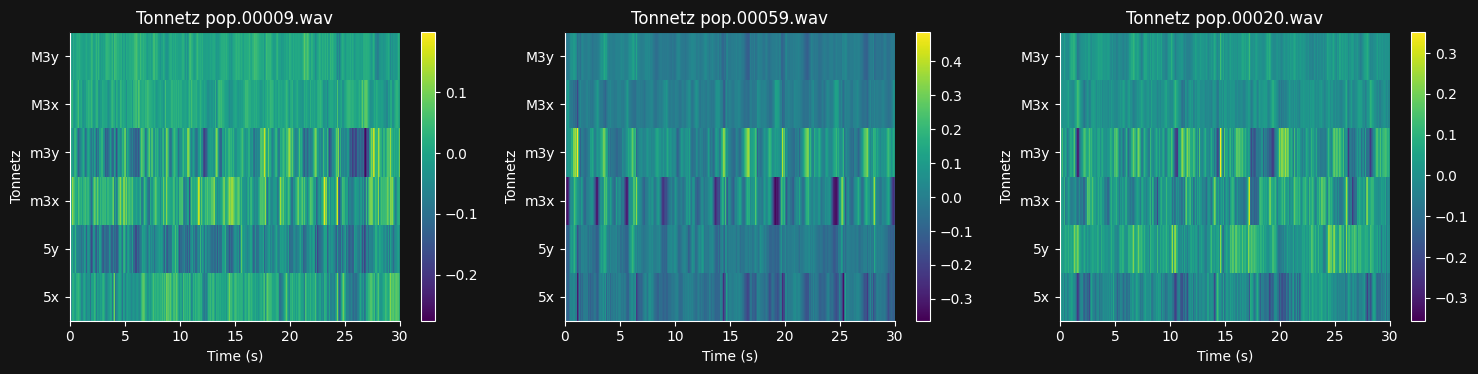

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/pop')

#### Reggae

<ipython-input-26-7de228fa64a6>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


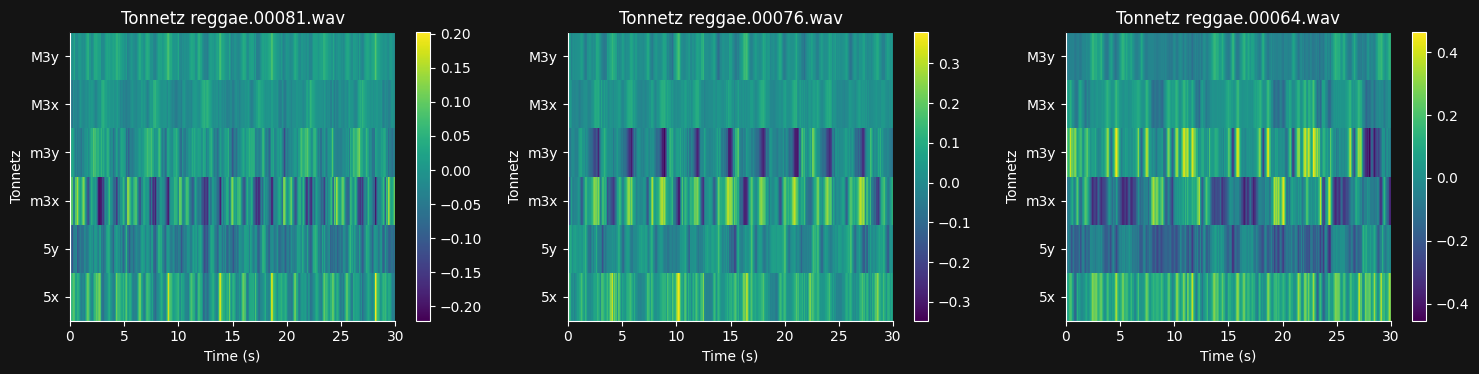

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/reggae')

#### Rock

<ipython-input-26-7de228fa64a6>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color='white')


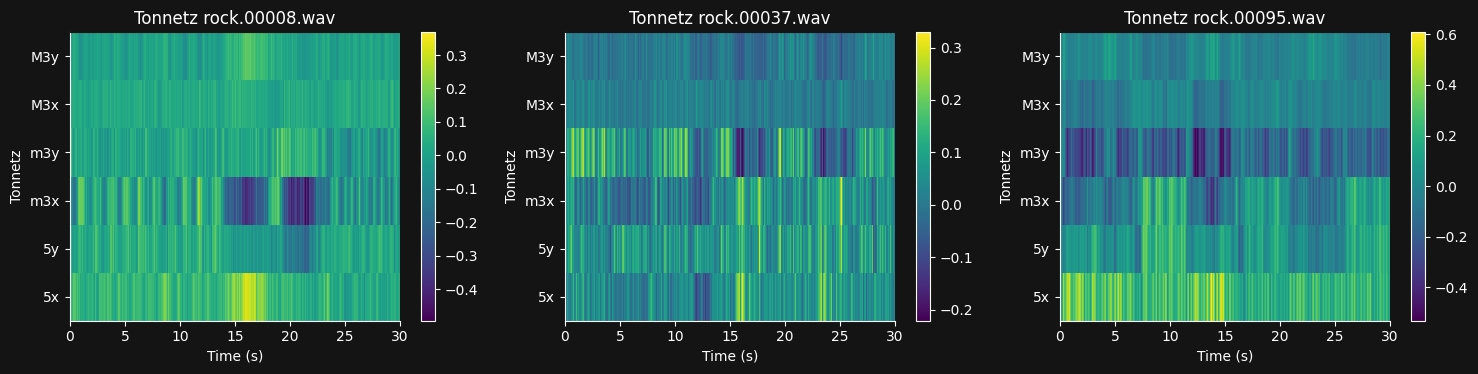

In [ ]:
# get the audio durations and output to a dataframe
plot_tonnetz('Data/genres_original/rock')

## Conclusions <a class="anchor" id="6"></a>

> Insights include:
  - Classical music seems to be the most distinctive genre after visually observing the mel specotgrams, waveplots, and chroma vectors.
  - Classical music may be the genre that the algorithm recognises best.
  - The other genres are less distinctive.